# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

#### 17 Marketing campaigns which were conducted between May 2008 and November 2010

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, make_scorer

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

import seaborn as sns

import prac3app_utils

import time

In [3]:
df_full = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df_full.shape[0]

41188

In [5]:
df_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
#Convert columns to appropriate datatypes. 
#In particular, convert categorical variables from object type to string type

df_full = df_full.convert_dtypes()
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  Int64  
 1   job             41188 non-null  string 
 2   marital         41188 non-null  string 
 3   education       41188 non-null  string 
 4   default         41188 non-null  string 
 5   housing         41188 non-null  string 
 6   loan            41188 non-null  string 
 7   contact         41188 non-null  string 
 8   month           41188 non-null  string 
 9   day_of_week     41188 non-null  string 
 10  duration        41188 non-null  Int64  
 11  campaign        41188 non-null  Int64  
 12  pdays           41188 non-null  Int64  
 13  previous        41188 non-null  Int64  
 14  poutcome        41188 non-null  string 
 15  emp.var.rate    41188 non-null  Float64
 16  cons.price.idx  41188 non-null  Float64
 17  cons.conf.idx   41188 non-null 

In [8]:
#Check for null values
df_full.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#### No null values are present.

#### Let's understand the data

#### Start with tghe distrbution of the target variable 'y'

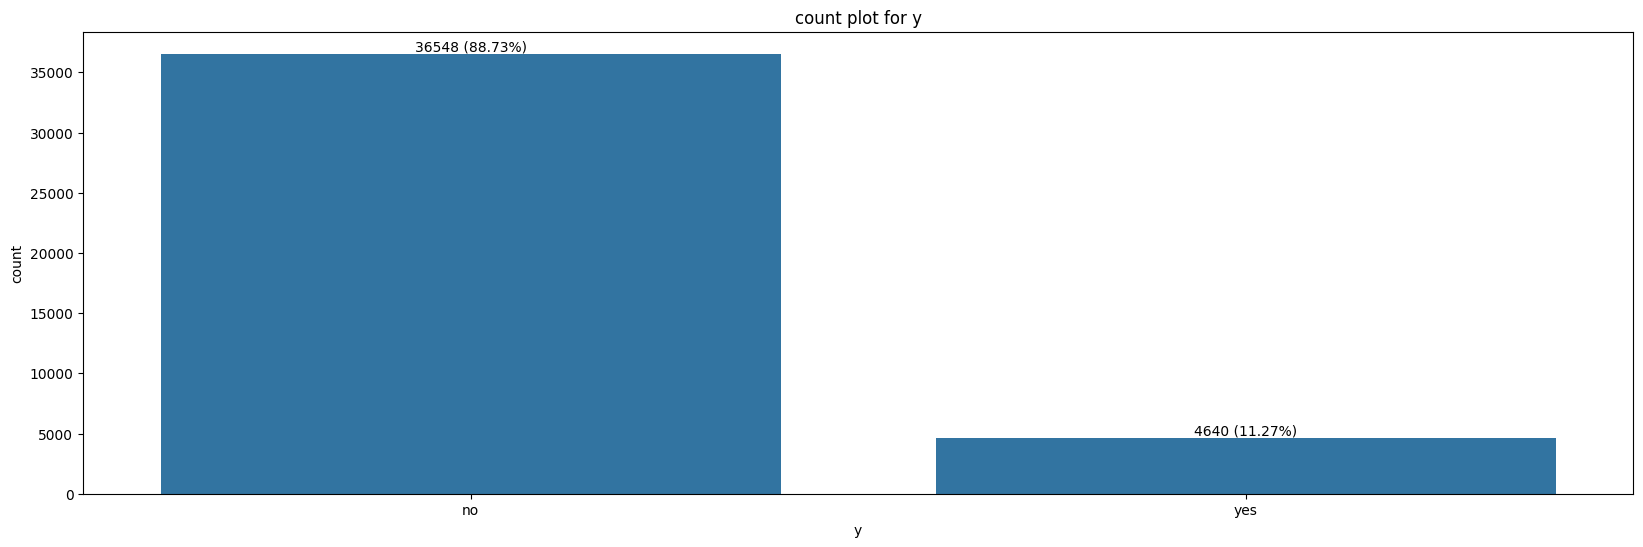

In [9]:
prac3app_utils.pretty_value_count_plot(df_full, 'y', 'count plot for y')

In [10]:
# Retrieve continuous/numerical features
num_features = df_full.select_dtypes(include=['Int64', 'Float64']).columns
print(num_features)

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


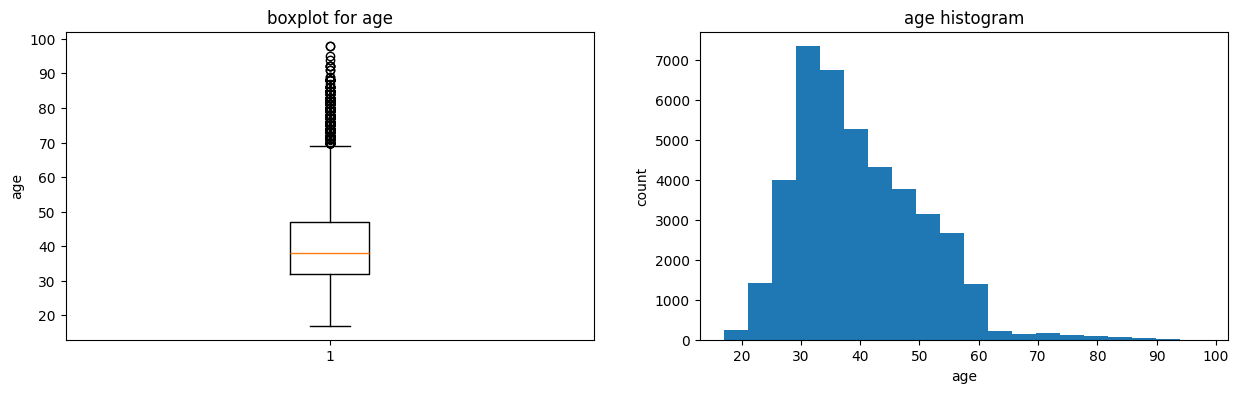

Max age : 98   Median  age : 38.0   Mean  age : 40.02406040594348   Min  age : 17   Q1  age : 32.0   Q2  age : 47.0   IQR  age : 15.0
 Outlier Row Count: 469  Outlier Row Percent: 1.1386811692726035 %
 Outlier Max: 98  Outlier Median: 76.0  Outlier Mean: 76.9275053304904  Outlier Min: 70


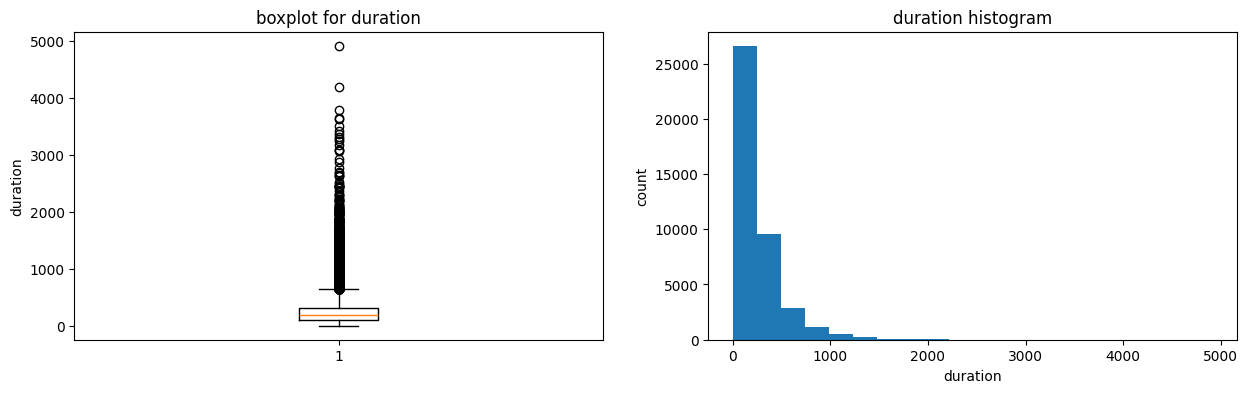

Max duration : 4918   Median  duration : 180.0   Mean  duration : 258.2850101971448   Min  duration : 0   Q1  duration : 102.0   Q2  duration : 319.0   IQR  duration : 217.0
 Outlier Row Count: 2963  Outlier Row Percent: 7.193842866854423 %
 Outlier Max: 4918  Outlier Median: 854.0  Outlier Mean: 968.2170097873776  Outlier Min: 645


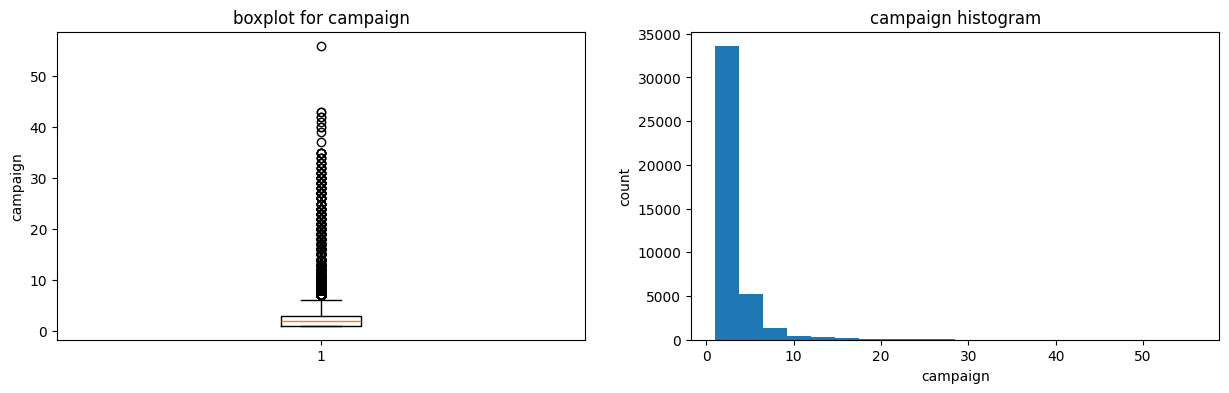

Max campaign : 56   Median  campaign : 2.0   Mean  campaign : 2.567592502670681   Min  campaign : 1   Q1  campaign : 1.0   Q2  campaign : 3.0   IQR  campaign : 2.0
 Outlier Row Count: 2406  Outlier Row Percent: 5.8415072351170245 %
 Outlier Max: 56  Outlier Median: 9.0  Outlier Mean: 11.004156275976724  Outlier Min: 7


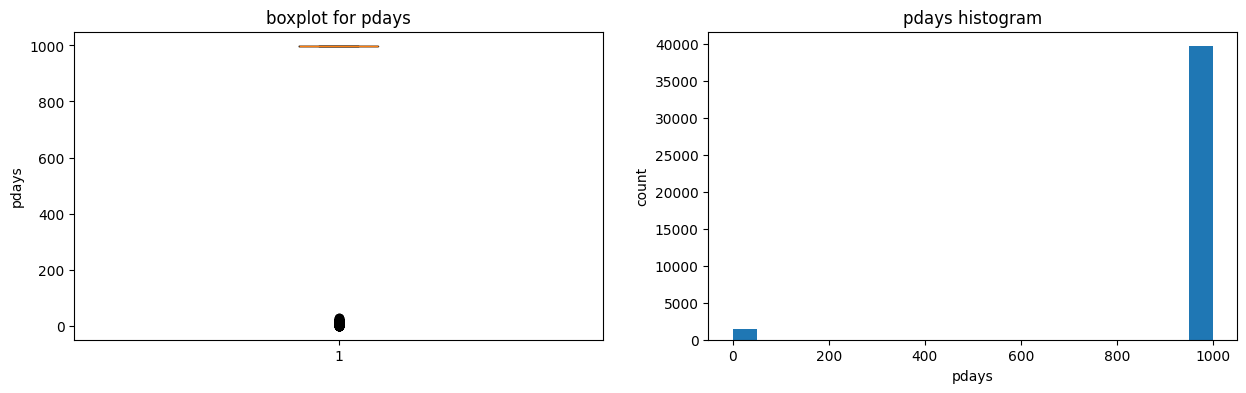

Max pdays : 999   Median  pdays : 999.0   Mean  pdays : 962.4754540157328   Min  pdays : 0   Q1  pdays : 999.0   Q2  pdays : 999.0   IQR  pdays : 0.0
 Outlier Row Count: 1515  Outlier Row Percent: 3.6782558026609693 %
 Outlier Max: 27  Outlier Median: 6.0  Outlier Mean: 6.014521452145215  Outlier Min: 0


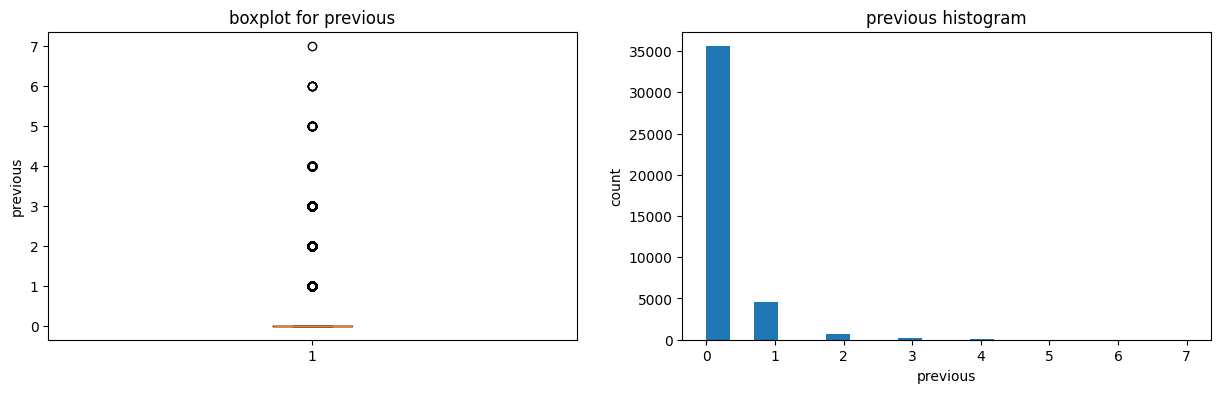

Max previous : 7   Median  previous : 0.0   Mean  previous : 0.17296299893172767   Min  previous : 0   Q1  previous : 0.0   Q2  previous : 0.0   IQR  previous : 0.0
 Outlier Row Count: 5625  Outlier Row Percent: 13.65689035641449 %
 Outlier Max: 7  Outlier Median: 1.0  Outlier Mean: 1.266488888888889  Outlier Min: 1


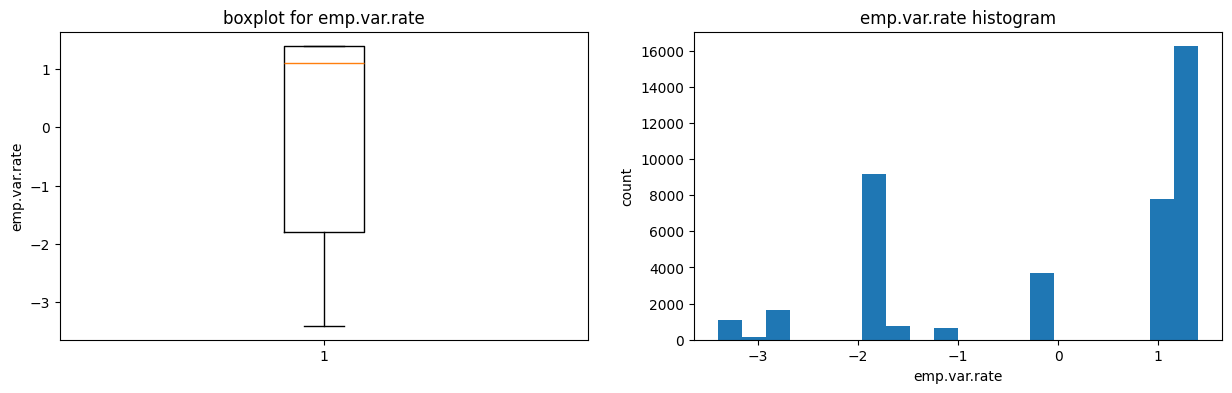

Max emp.var.rate : 1.4   Median  emp.var.rate : 1.1   Mean  emp.var.rate : 0.08188550063125165   Min  emp.var.rate : -3.4   Q1  emp.var.rate : -1.8   Q2  emp.var.rate : 1.4   IQR  emp.var.rate : 3.2
 Outlier Row Count: 0  Outlier Row Percent: 0.0 %
 Outlier Max: <NA>  Outlier Median: <NA>  Outlier Mean: <NA>  Outlier Min: <NA>


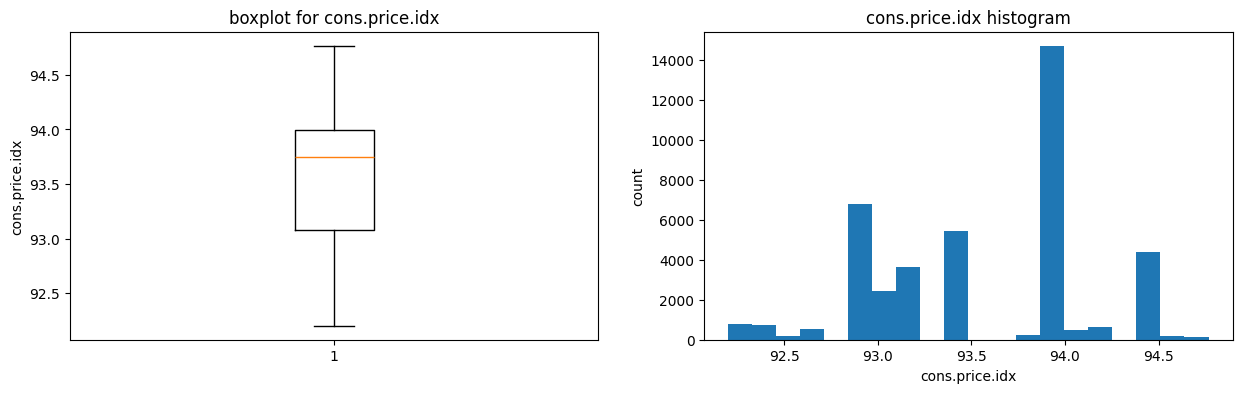

Max cons.price.idx : 94.767   Median  cons.price.idx : 93.749   Mean  cons.price.idx : 93.57566436826262   Min  cons.price.idx : 92.201   Q1  cons.price.idx : 93.075   Q2  cons.price.idx : 93.994   IQR  cons.price.idx : 0.9189999999999969
 Outlier Row Count: 0  Outlier Row Percent: 0.0 %
 Outlier Max: <NA>  Outlier Median: <NA>  Outlier Mean: <NA>  Outlier Min: <NA>


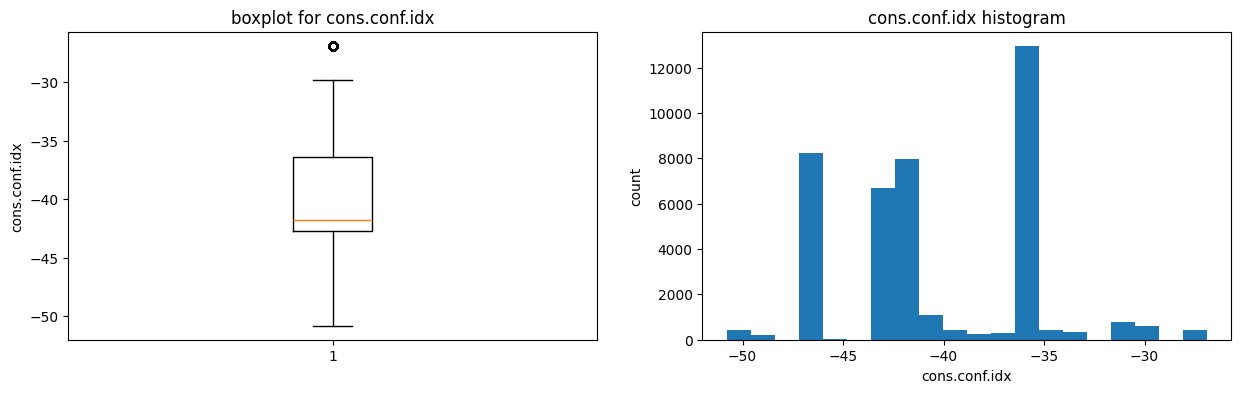

Max cons.conf.idx : -26.9   Median  cons.conf.idx : -41.8   Mean  cons.conf.idx : -40.50260027192386   Min  cons.conf.idx : -50.8   Q1  cons.conf.idx : -42.7   Q2  cons.conf.idx : -36.4   IQR  cons.conf.idx : 6.300000000000004
 Outlier Row Count: 447  Outlier Row Percent: 1.0852675536564047 %
 Outlier Max: -26.9  Outlier Median: -26.9  Outlier Mean: -26.9  Outlier Min: -26.9


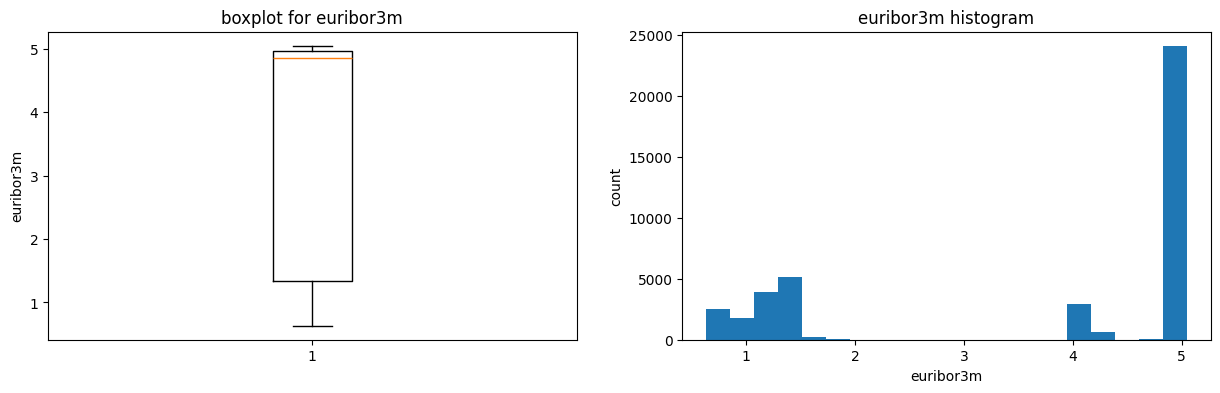

Max euribor3m : 5.045   Median  euribor3m : 4.857   Mean  euribor3m : 3.621290812858114   Min  euribor3m : 0.634   Q1  euribor3m : 1.344   Q2  euribor3m : 4.961   IQR  euribor3m : 3.617
 Outlier Row Count: 0  Outlier Row Percent: 0.0 %
 Outlier Max: <NA>  Outlier Median: <NA>  Outlier Mean: <NA>  Outlier Min: <NA>


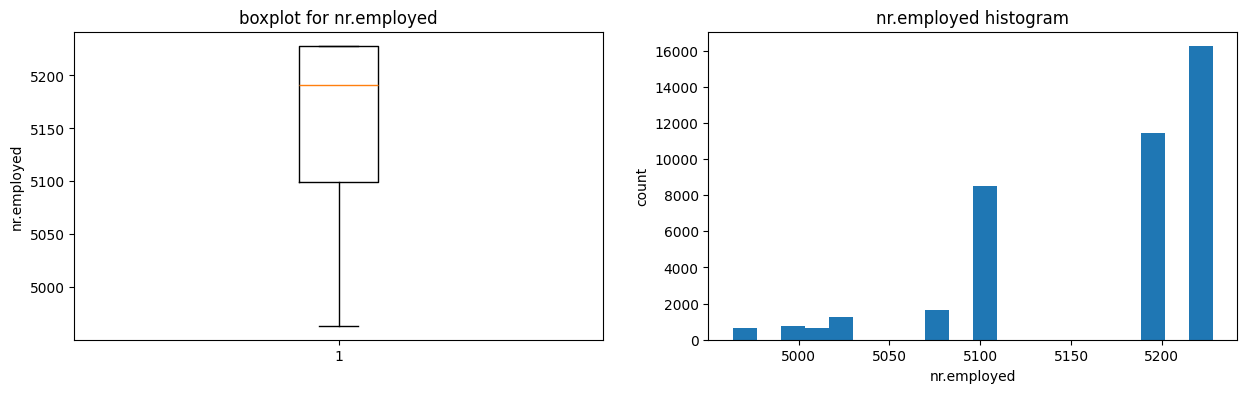

Max nr.employed : 5228.1   Median  nr.employed : 5191.0   Mean  nr.employed : 5167.035910944936   Min  nr.employed : 4963.6   Q1  nr.employed : 5099.1   Q2  nr.employed : 5228.1   IQR  nr.employed : 129.0
 Outlier Row Count: 0  Outlier Row Percent: 0.0 %
 Outlier Max: <NA>  Outlier Median: <NA>  Outlier Mean: <NA>  Outlier Min: <NA>


In [11]:
#Analyze 
for n_feature in num_features:
    prac3app_utils.subplot_box_hist(df_full, n_feature, f'boxplot for {n_feature}', f'{n_feature} histogram')
    prac3app_utils.analyze_outliers(df_full, n_feature, 1.5)

#### Analysis of Numerical Variables/Features

##### <i>pdays</i> and <i>poutcome</i> distributions are skewed based on these plots. Plotting count plots to get a better picture.


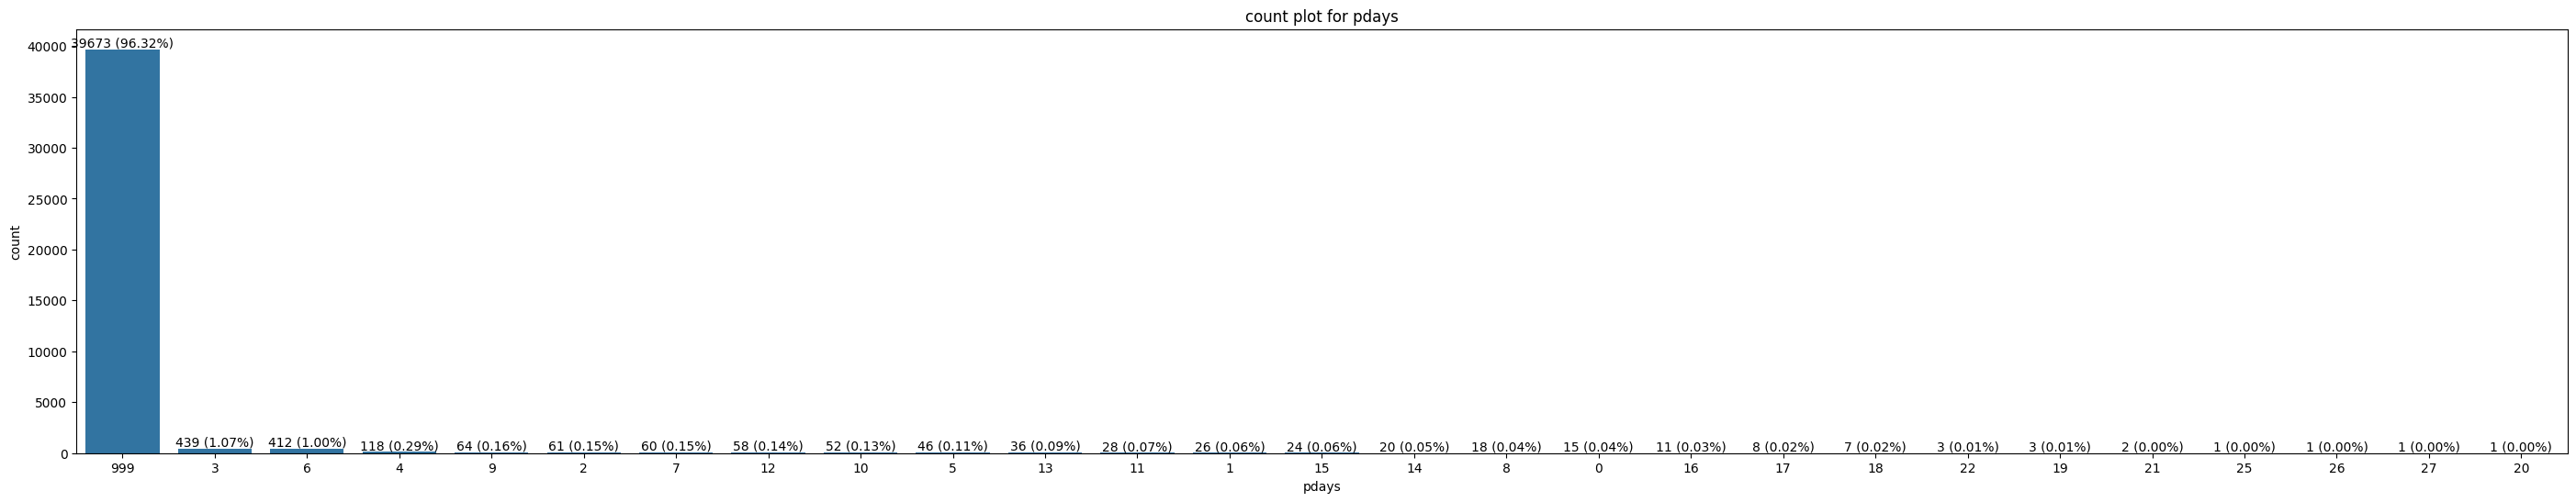

In [12]:
prac3app_utils.pretty_value_count_plot(df_full, 'pdays', 'count plot for pdays', 35, 6)

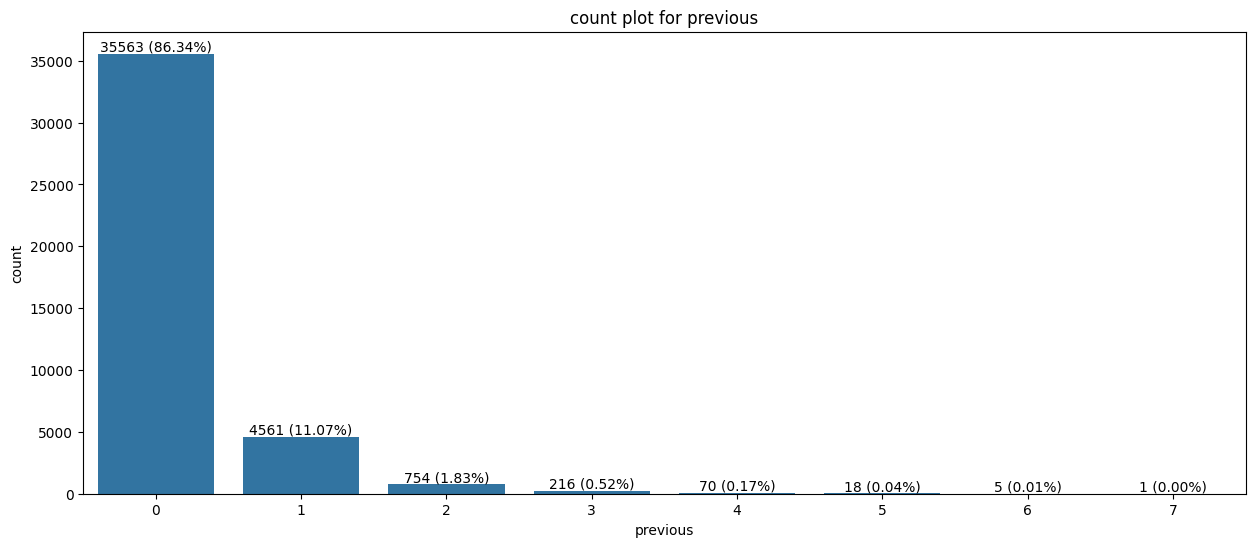

In [13]:
prac3app_utils.pretty_value_count_plot(df_full, 'previous', 'count plot for previous', 15, 6)

##### 96% of rows for the <i>pdays</i> column has the same value. Therefore, this column can be dropped
##### 86.34% of rows for the <i>previous</i> column has the same value. Therefore, this column can be dropped


##### 1.13% of rows are outliers for the column <i>age</i> and about 5.84% of rows are outliers for the column <i>campaign</i>. I am not going to drop those rows as the dataset contains only about 41K rows.

##### <i>duration</i> column can be dropped based on the description

In [14]:
# Dropping columns pdays, previous and duration

df_full = df_full.drop(['pdays', 'previous', 'duration'], axis=1)
df_full.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y'],
      dtype='object')

#### Analysis of Categorical Variables/Features

In [15]:
target = 'y'
cat_features = df_full.select_dtypes(include=['string']).columns
print(cat_features)
print(type(cat_features))

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')
<class 'pandas.core.indexes.base.Index'>


In [16]:
#Ch-sq Test for feature independence
for feature in cat_features:
    if(feature != target):
        prac3app_utils.do_cat_cat_feature_independence_chisq_test(feature, target, df_full[feature], df_full[target])

job  is likely dependent
marital  is likely dependent
education  is likely dependent
default  is likely dependent
housing  is likely independent
loan  is likely independent
contact  is likely dependent
month  is likely dependent
day_of_week  is likely dependent
poutcome  is likely dependent


<b> Since most of the  categorical features are likely dependent, I am going to look at count plots to discard anomalous columns </b>

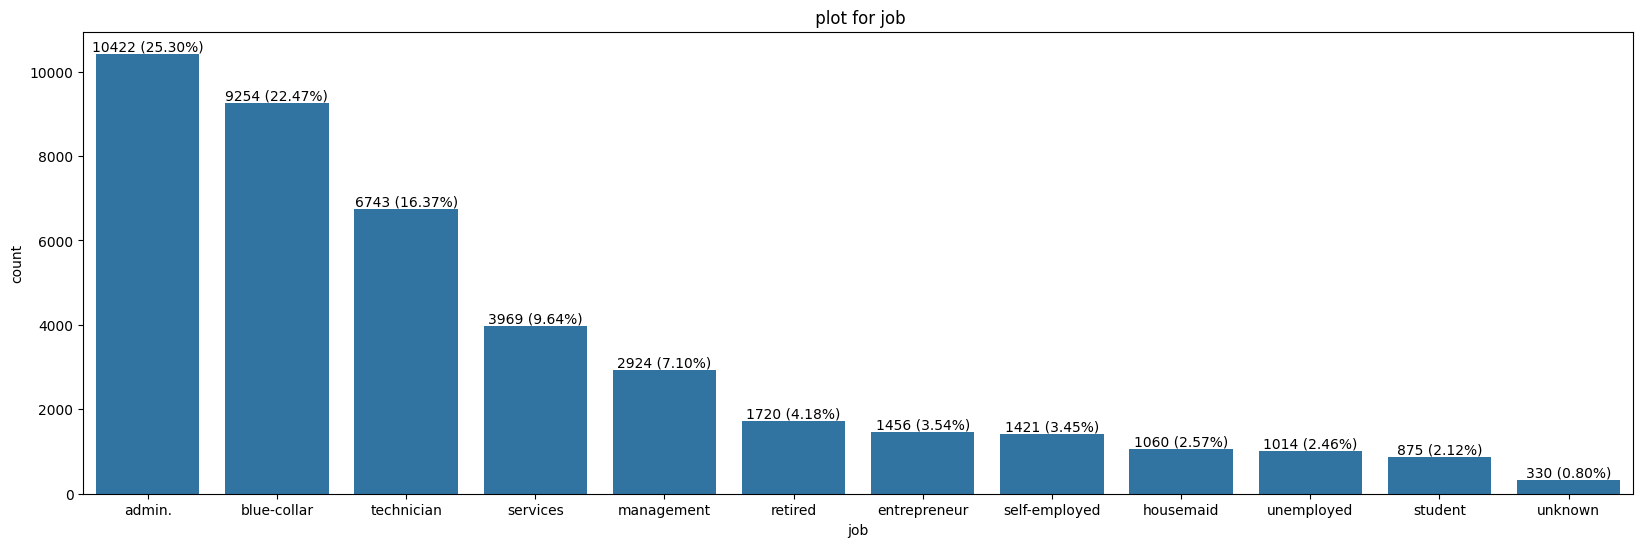

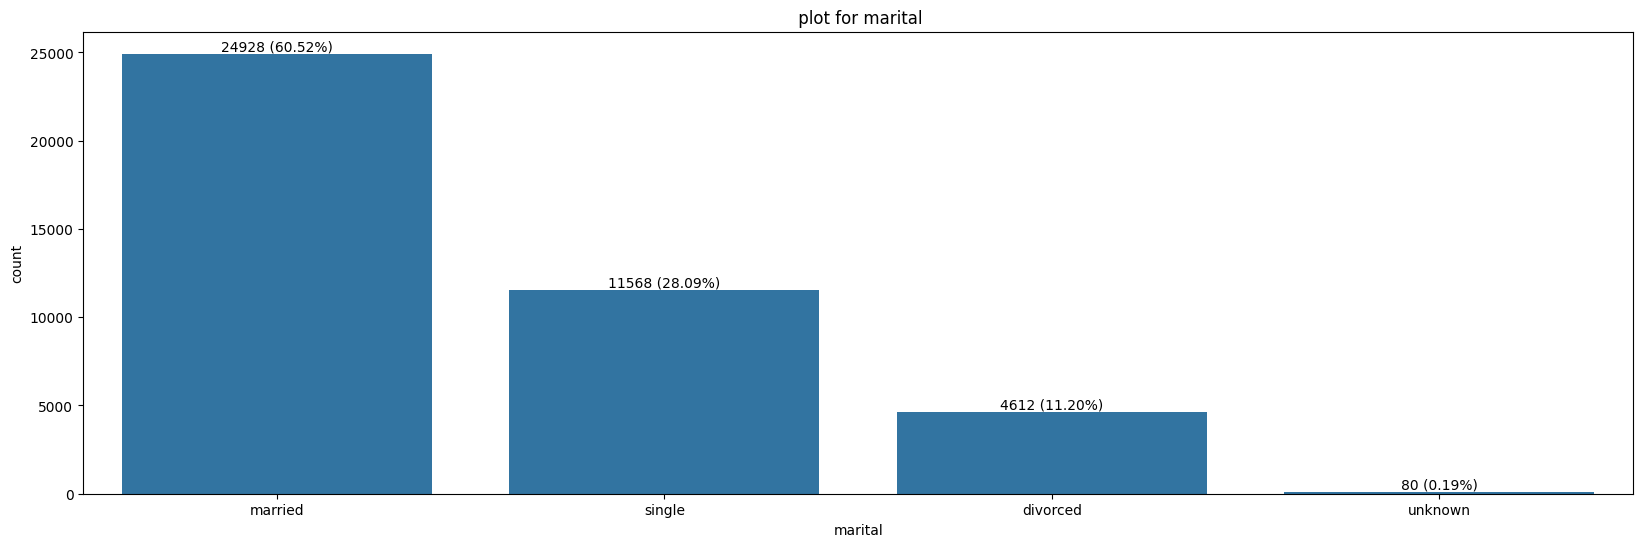

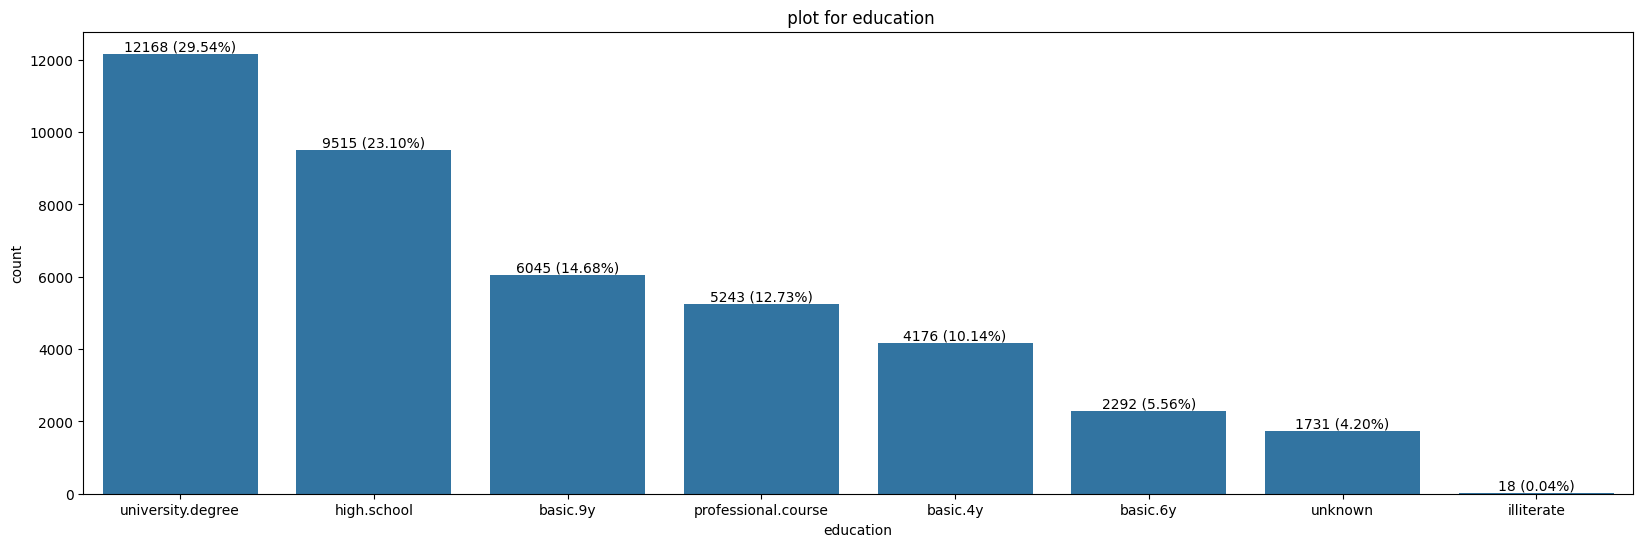

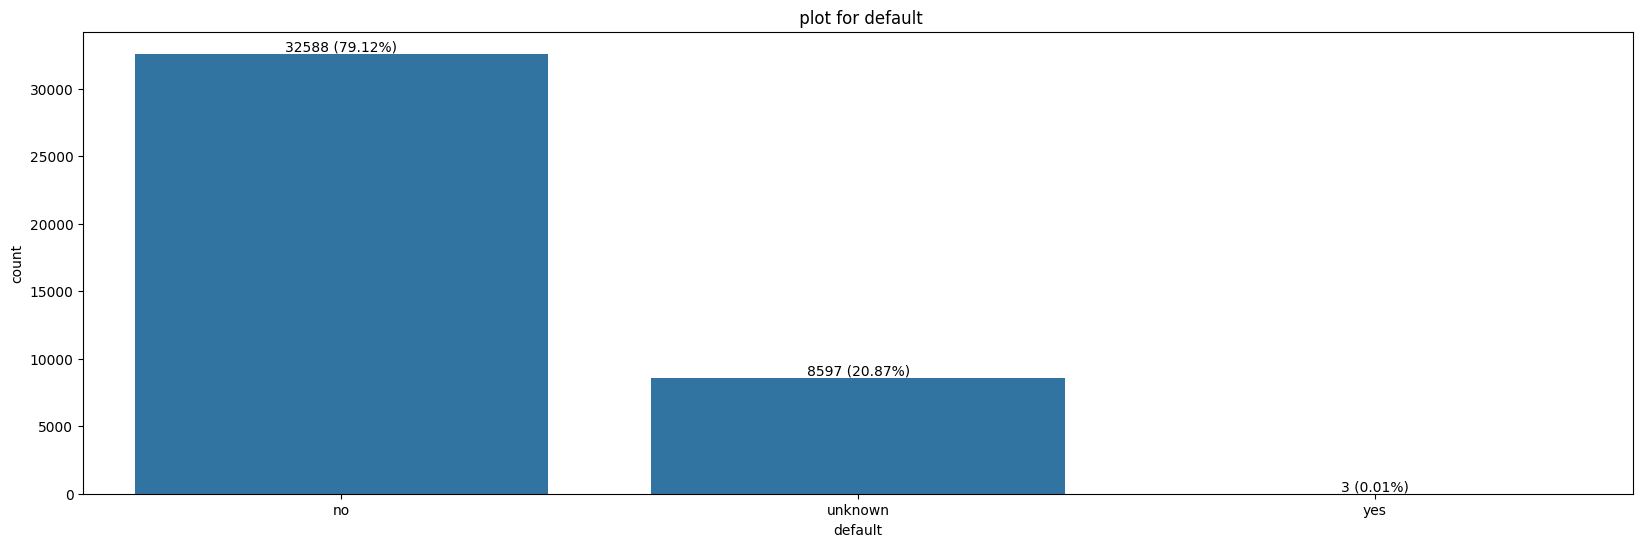

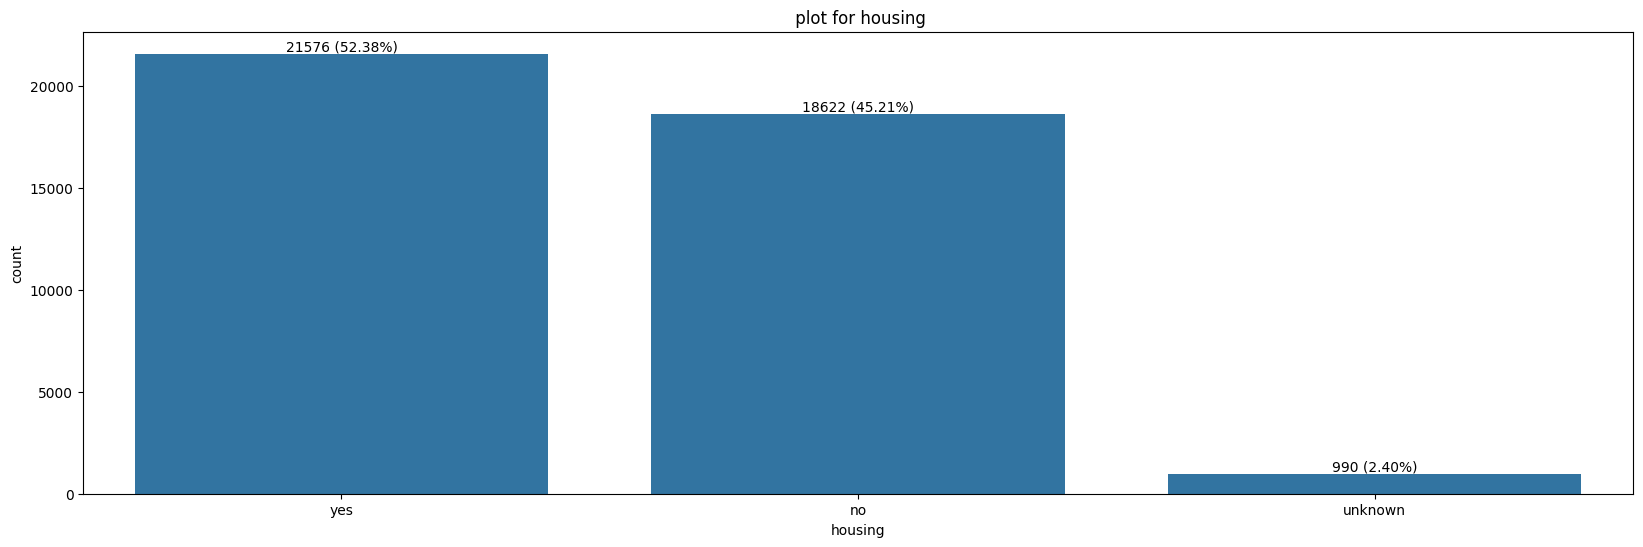

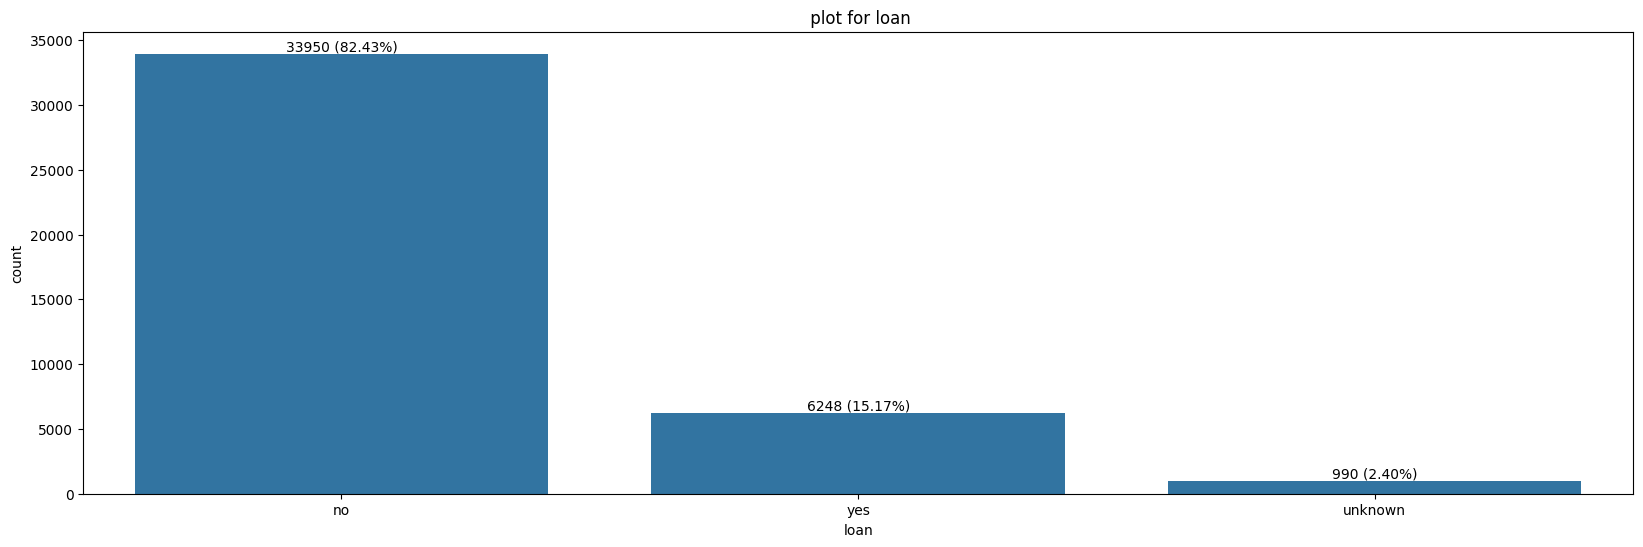

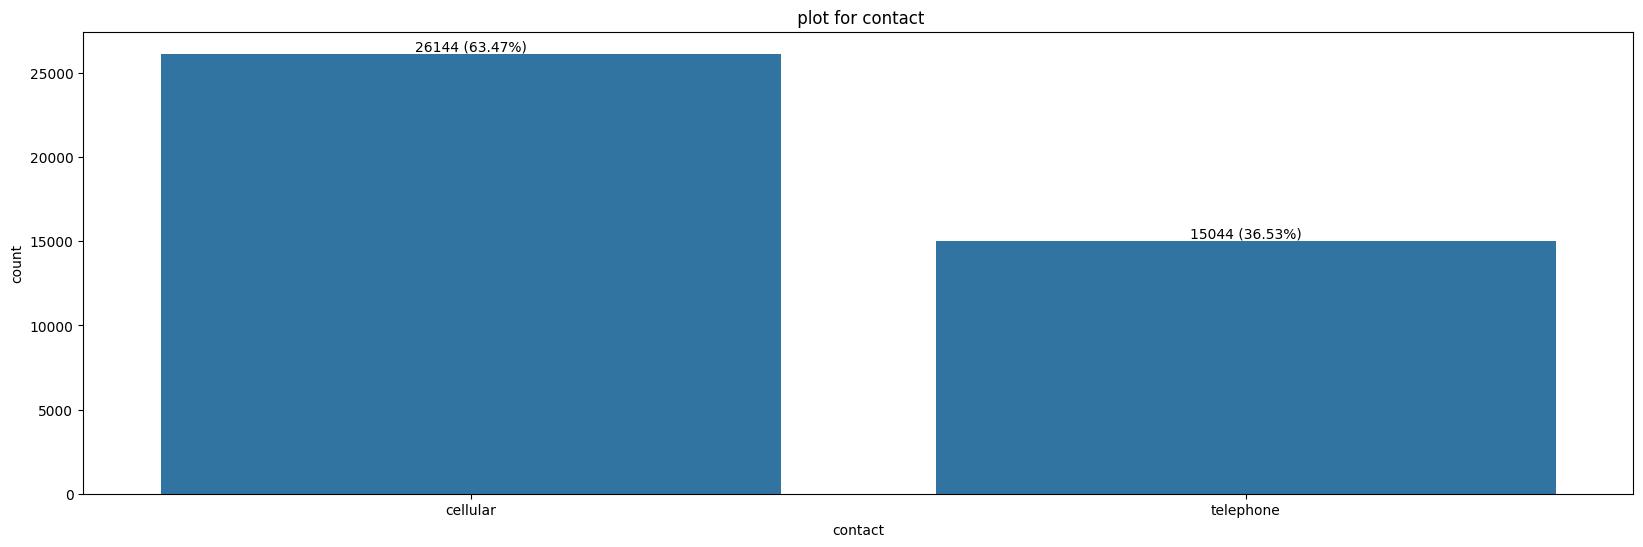

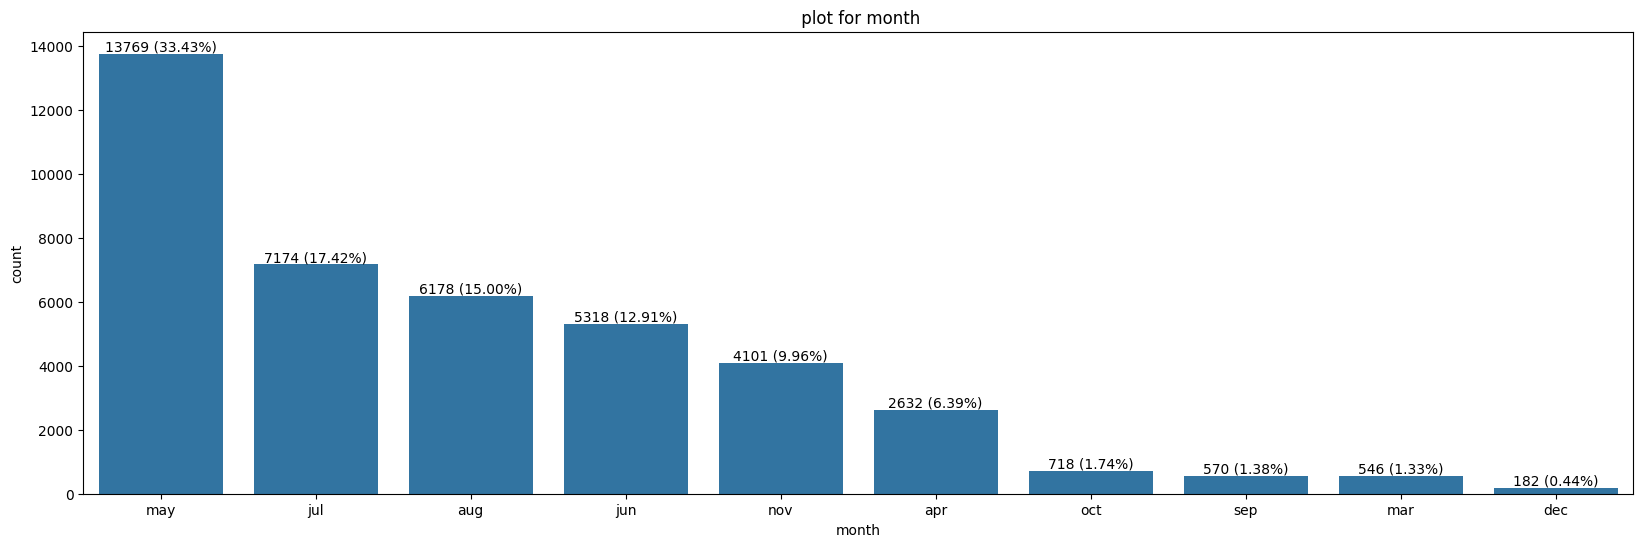

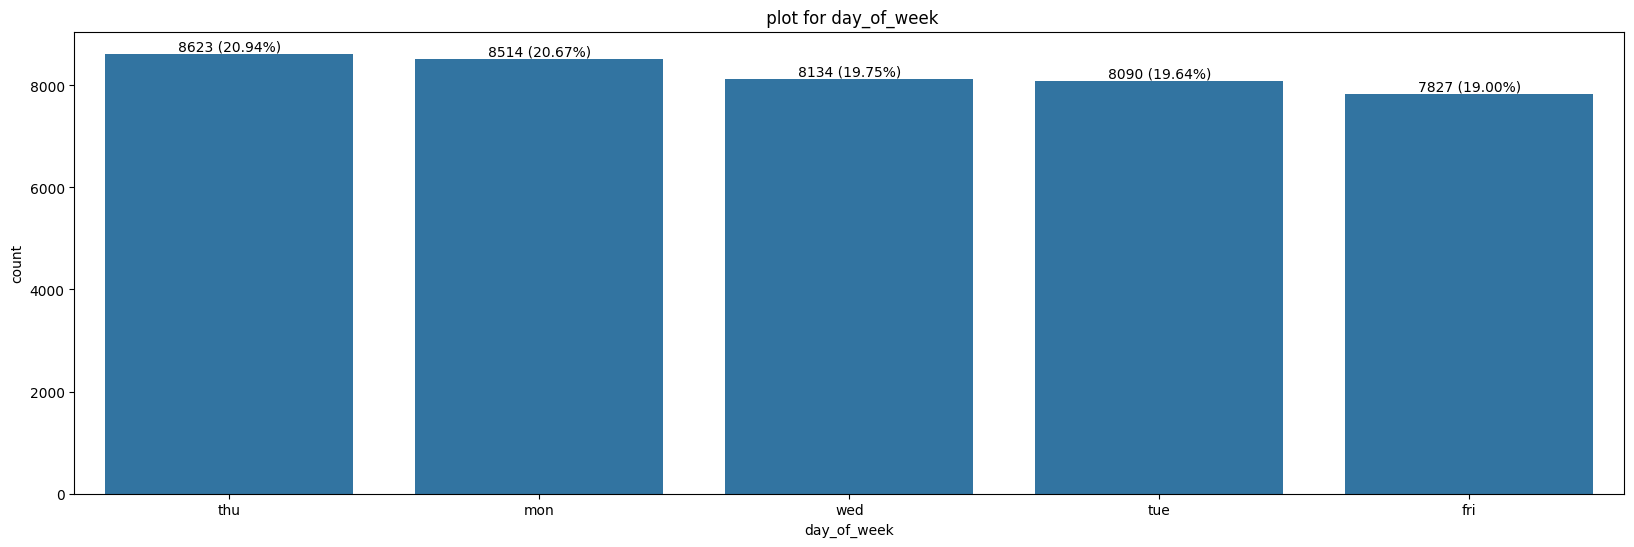

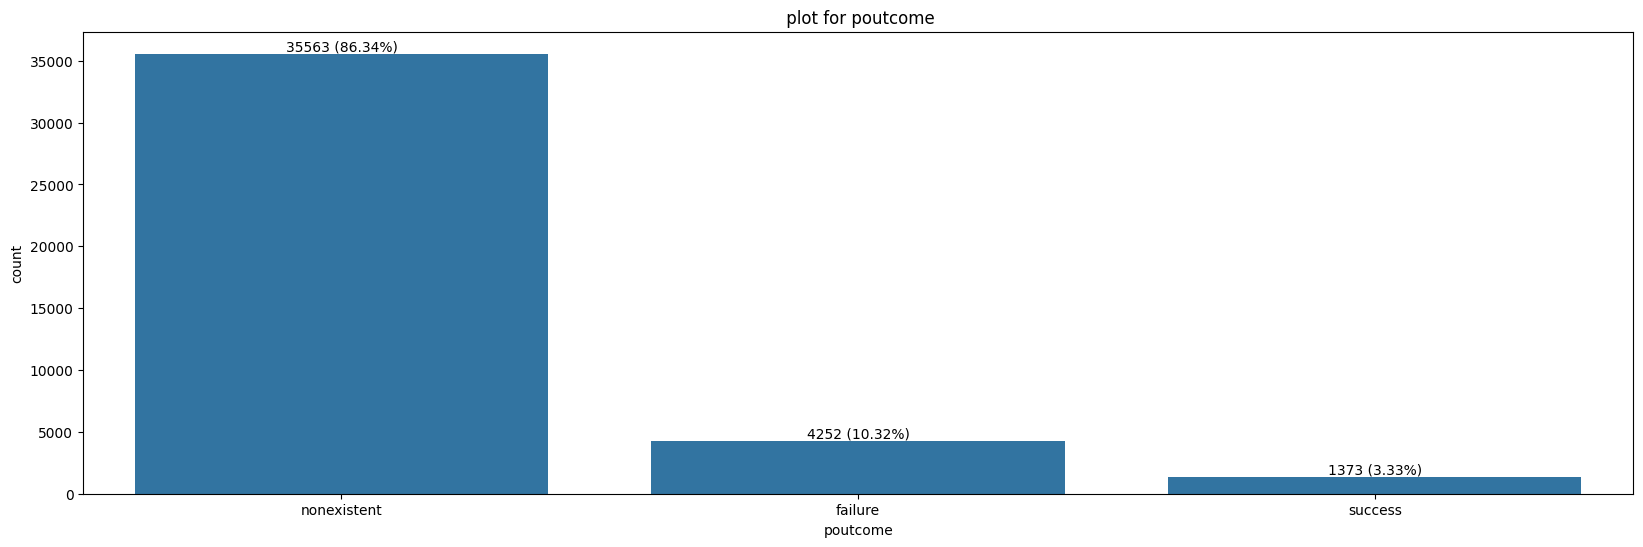

In [17]:
for feature in cat_features:
    if(feature != target):
        prac3app_utils.pretty_value_count_plot(df_full, feature, f' plot for {feature}')

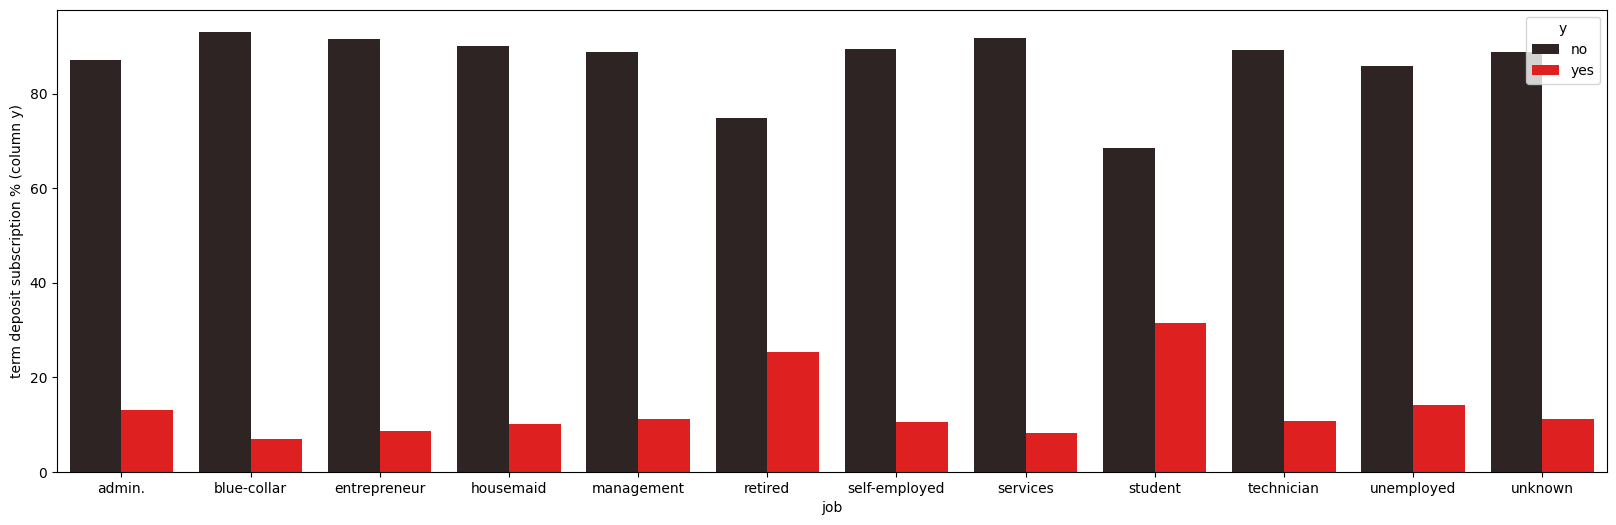

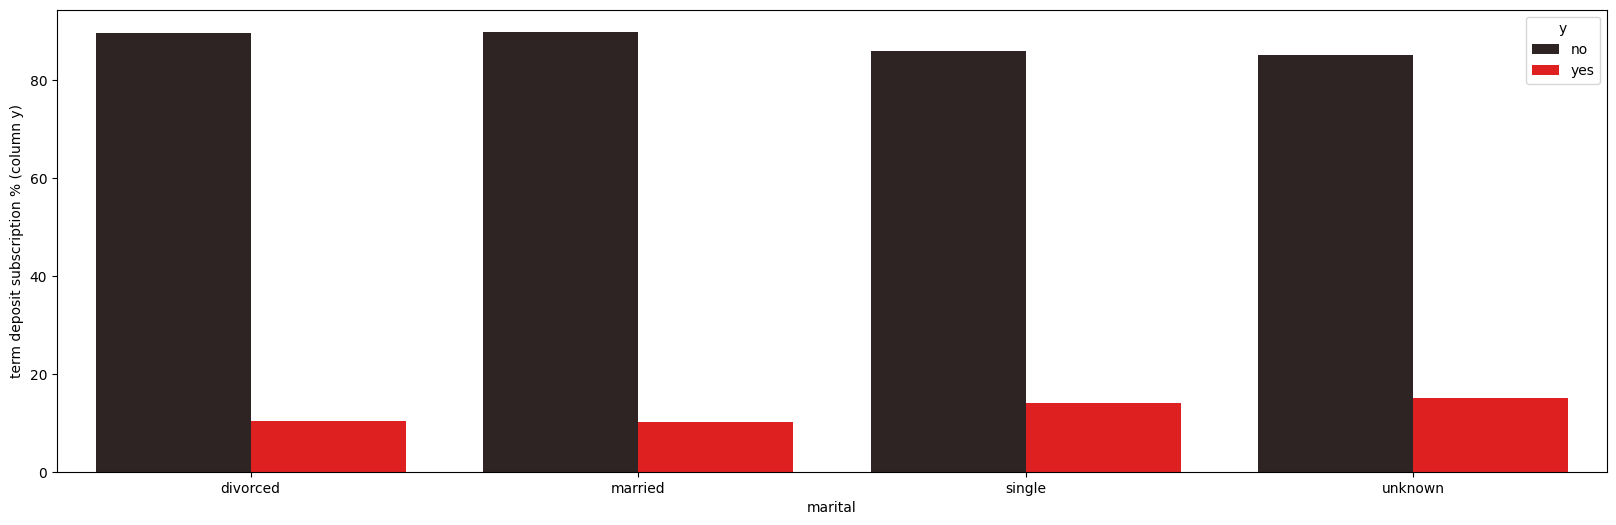

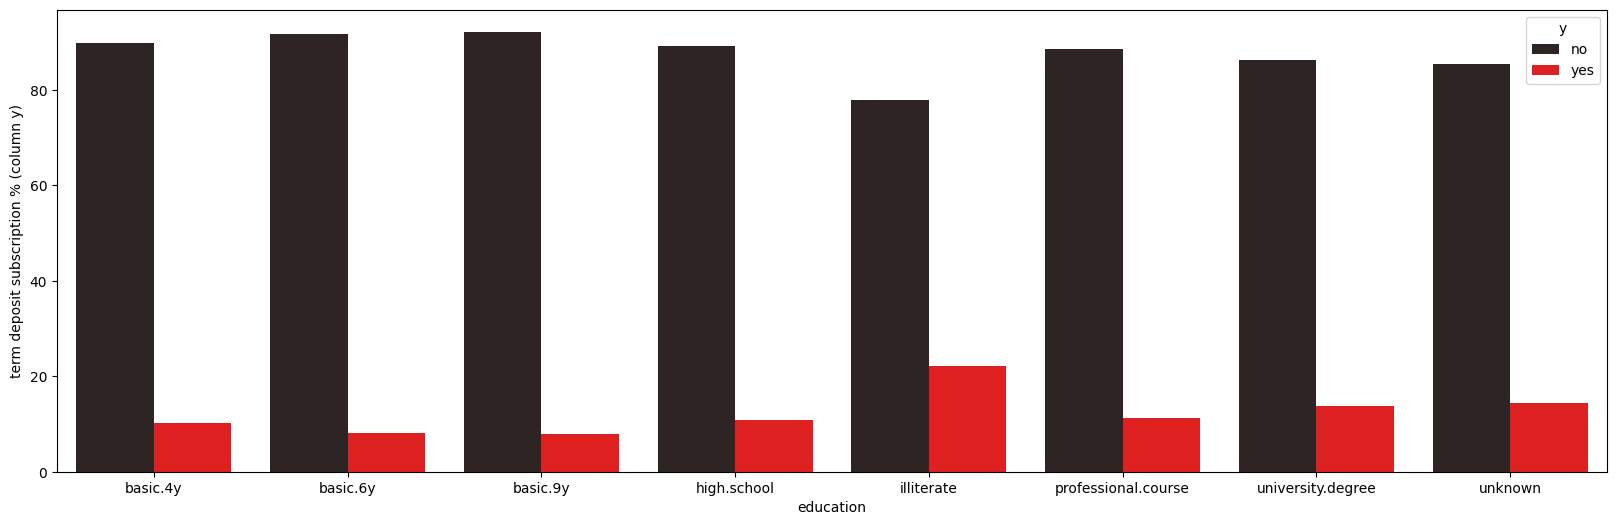

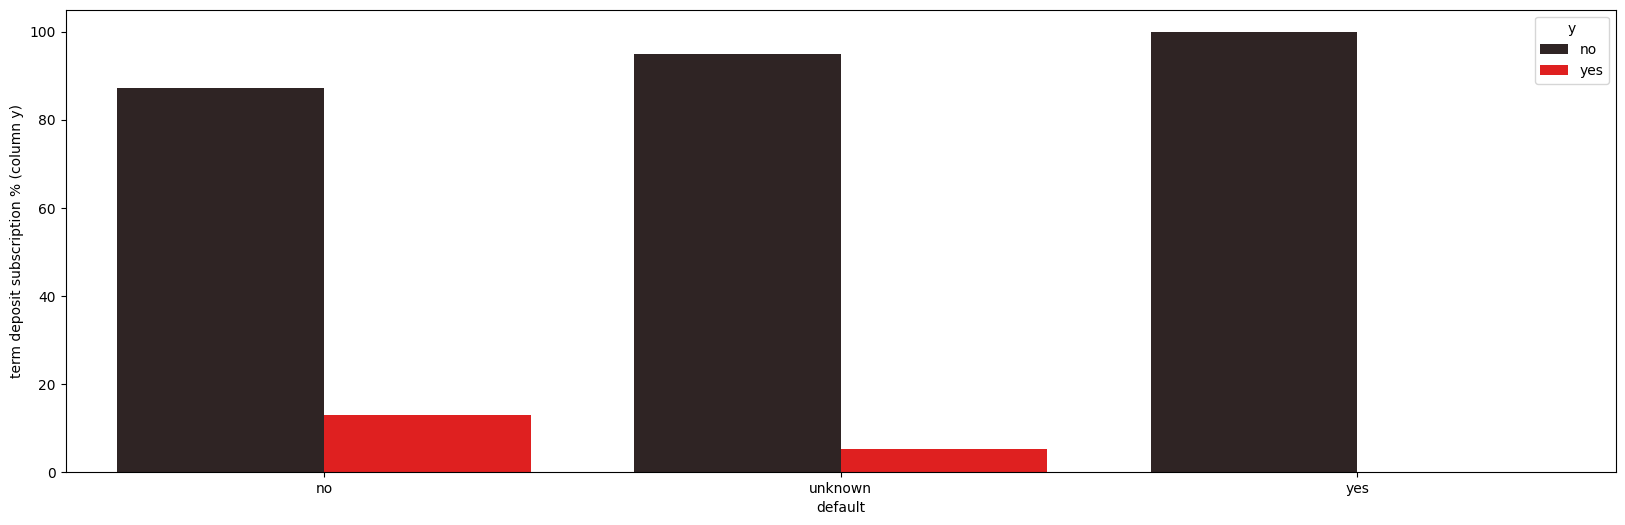

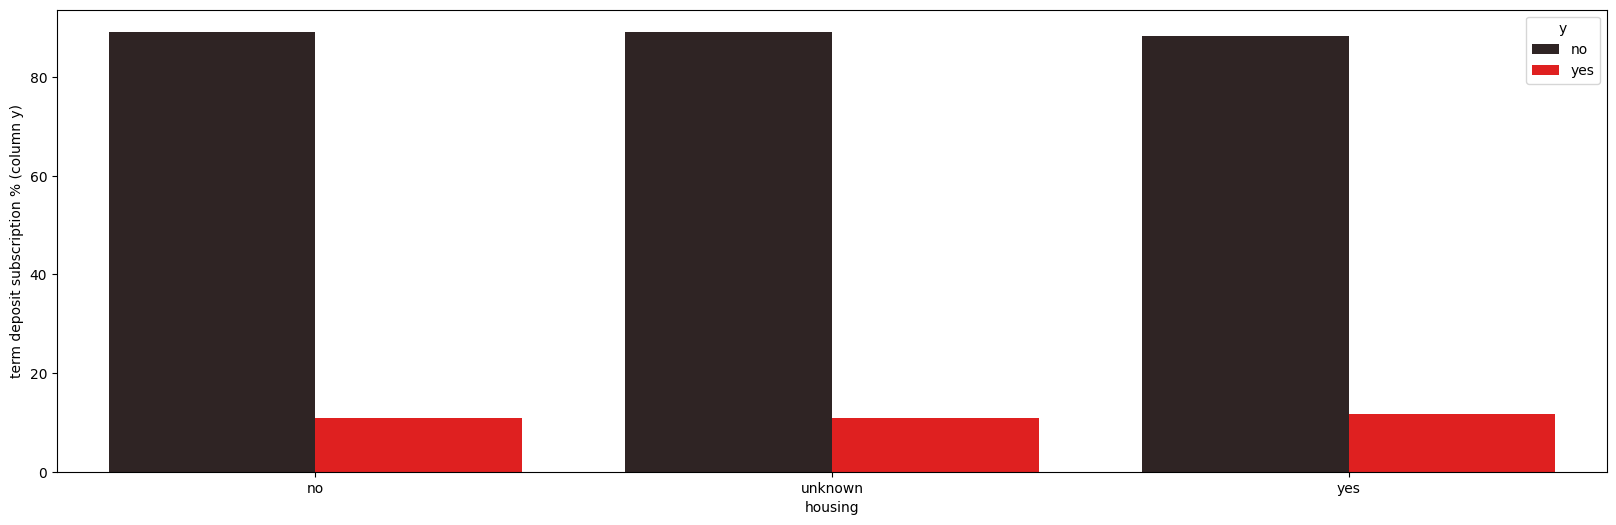

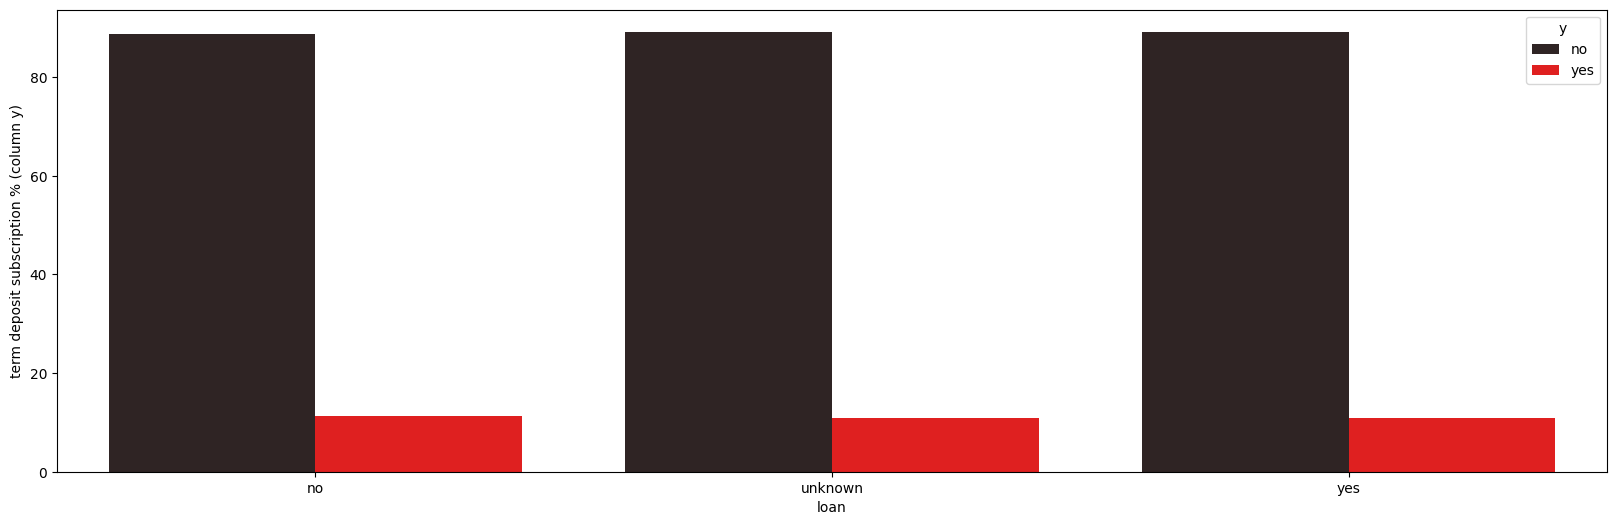

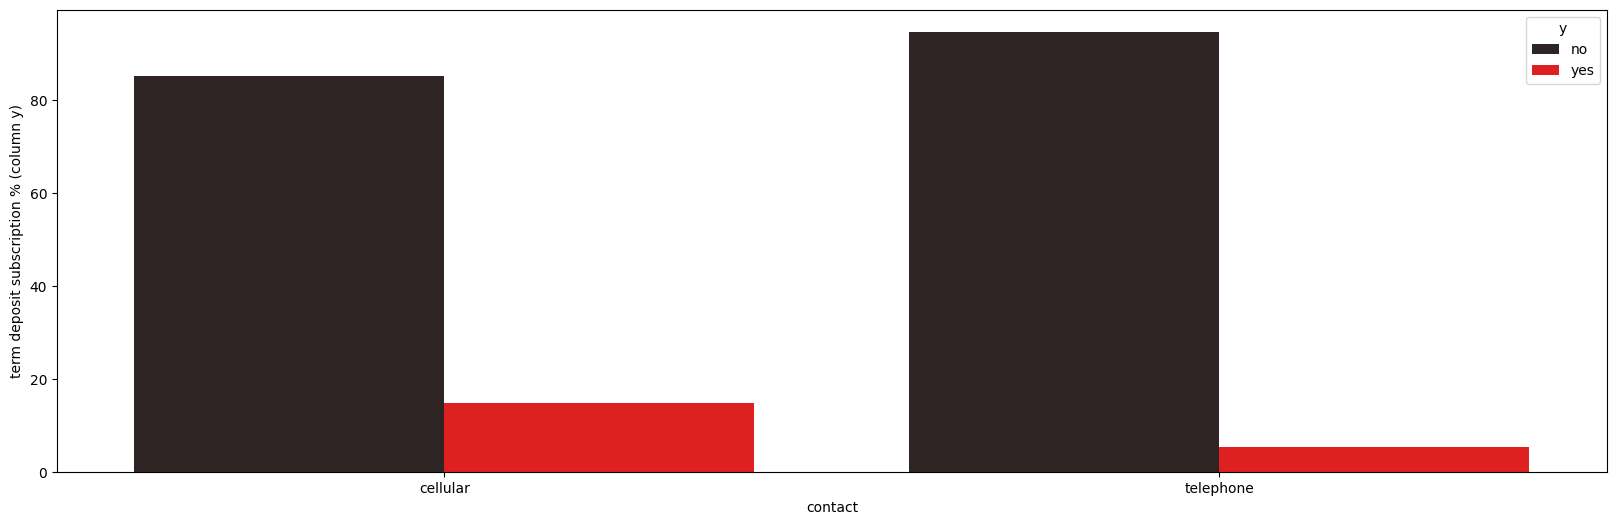

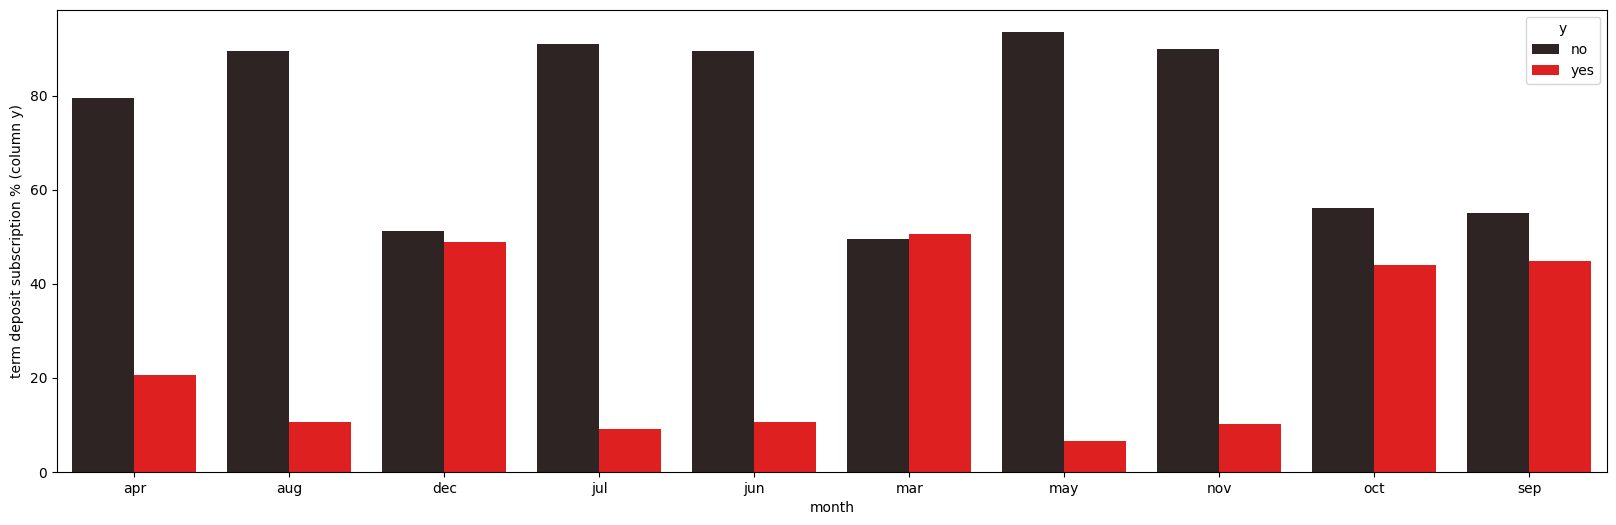

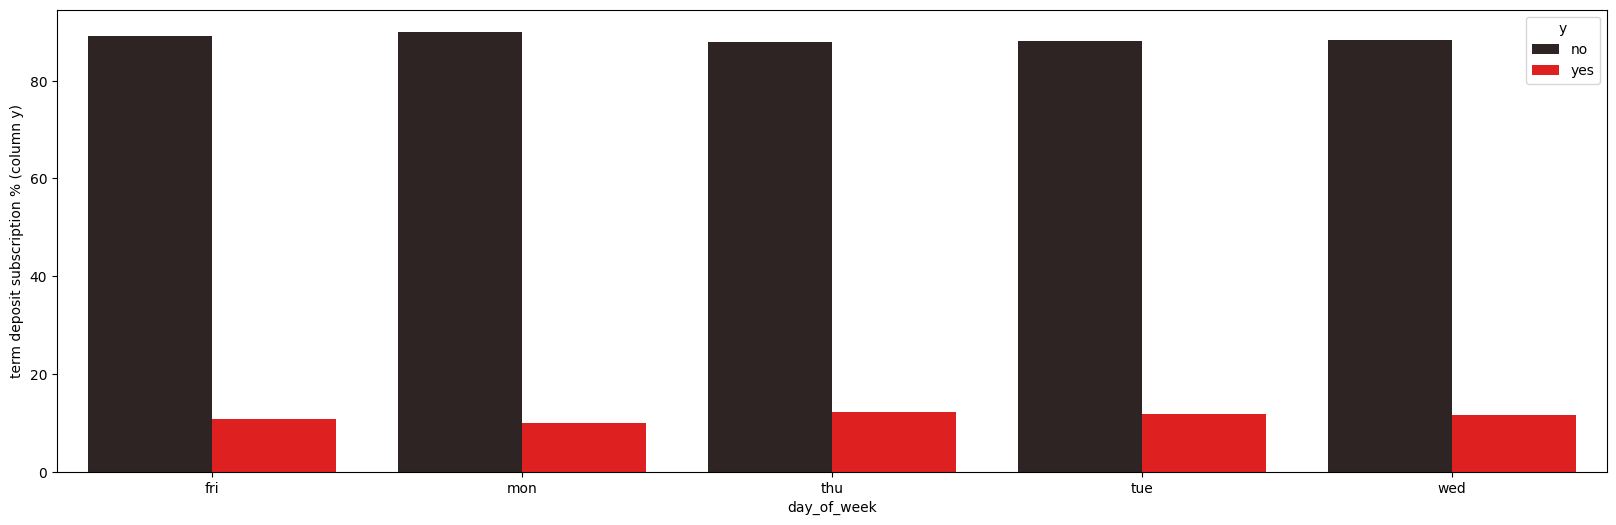

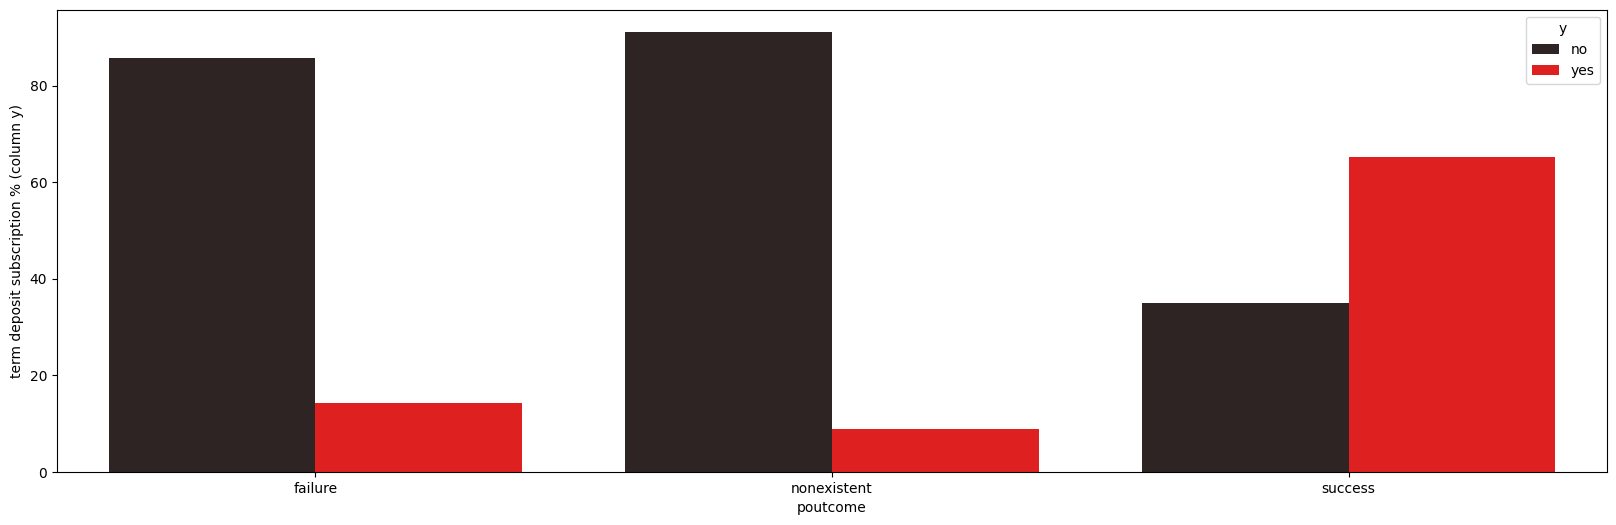

In [18]:
for feature in cat_features:
    if(feature != target):
        prac3app_utils.plot_barplot_with_groupby(df_full, feature, target)

#### Analysis of Categorical Variables/Features

##### The count plot and group by plots for all categorical variables look fine.
##### The customer is more likely to subscribe to the term deposit when the outcome of the previous campaign is successful  (poutcome column )is successful.
##### Certain months lead to success as opposed to others
##### Day of the week, personal loan and housing by themselves don't affect the outcome

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The business objective is to evaluate multiple models to find an appropriate model to maximize client term deposit subscription prediction.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

Use  make_column_selector to select categorical features.  This selector will replace the list of column names in the make_column_transformer.



In [19]:
# numerical features
num_features = df_full.select_dtypes(include=['Int64', 'Float64']).columns
num_features

Index(['age', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')

In [20]:
# categorical features
cat_features = df_full.select_dtypes(include=['string']).columns
cat_features = cat_features.drop('y')
cat_features

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [21]:
print(type(cat_features))

<class 'pandas.core.indexes.base.Index'>


In [22]:
#Apply one hot encoding to all categorical variables and StandardScaler to all numerical variables.
col_transformer  = ColumnTransformer([("numerical", StandardScaler(), num_features), 
                                  ("categorical", OneHotEncoder(), cat_features)])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [23]:

X = df_full.drop('y', axis = 1)
y = df_full['y']


In [24]:
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed'],
      dtype='object')

In [25]:
y

0         no
1         no
2         no
3         no
4         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: y, Length: 41188, dtype: string

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, stratify = y )

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [27]:
baseline_pipe = Pipeline([
    ('col_transformer', col_transformer),
    ('dclf', DummyClassifier(strategy='most_frequent', random_state=42))
])
baseline_pipe.fit(X_train, y_train)
baseline_pipe_acc = baseline_pipe.score(X_test, y_test)
print(baseline_pipe_acc)


# Answer check
baseline_pipe

0.8873458288821987


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  Index(['age', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object'))])),
                ('dclf',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

In [28]:
model_score_df = pd.DataFrame(columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy', 'Recall', 'Precision'])


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [29]:
#Logistic Regression Pipe
lgr_pipe = Pipeline([ ('col_transformer', col_transformer), 
                     ("model", LogisticRegression())])
# Utility function to fit on the training data, calculate training time along with test/train accuracy.
lgr_train_time, lgr_pipe_test_acc, lgr_pipe_train_acc =  prac3app_utils.fit_pipe(lgr_pipe,  X_train, y_train, X_test, y_test)

print('lgr_train_time:', lgr_train_time, ' lgr_pipe_test_acc:',lgr_pipe_test_acc,'lgr_pipe_train_acc:',lgr_pipe_train_acc)




lgr_train_time: 0.09  lgr_pipe_test_acc: 0.9 lgr_pipe_train_acc: 0.9


### Problem 9: Score the Model

What is the accuracy of your model?

fp: 107 fn: 914 tp: 246 tn: 9030 auc: 0.81
recall: 0.21  precision: 0.7


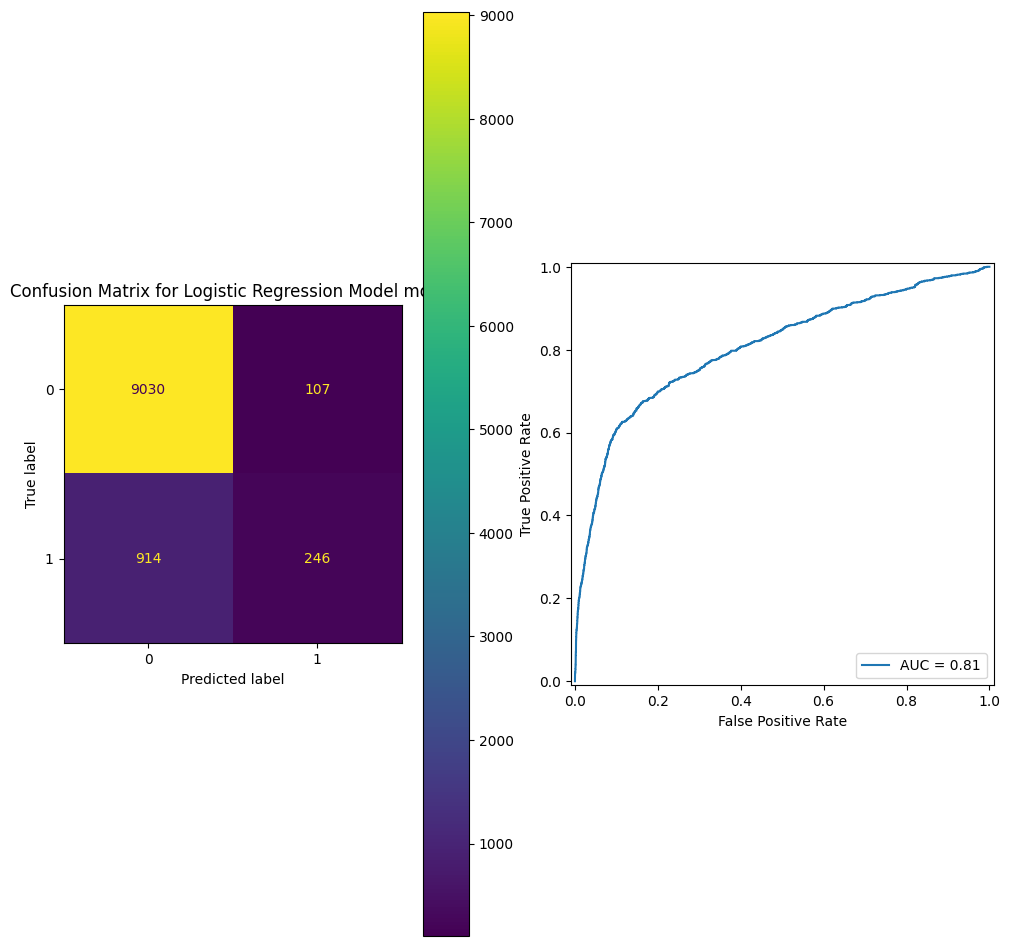

In [30]:
#Calculate confusion matrix and plot the ROC curve
lgr_fp, lgr_fn, lgr_tp, lgr_tn, lgr_auc, lgr_precision, lgr_recall = prac3app_utils.score_model_and_plot_roc_curve(lgr_pipe, 
                                                                                                              X_test, 
                                                                                                              y_test, 
                                                                                                              'Logistic Regression Model')
# create a dataframe row for logistic regression metrics
lgr_row = pd.DataFrame([{'Model': 'Logistic Regression', 'Train Time': lgr_train_time, 'Train Accuracy': lgr_pipe_train_acc, 
                        "Test Accuracy": lgr_pipe_test_acc, 'Recall': lgr_recall, 'Precision':lgr_precision}], index = [0])

In [31]:
# Decision Tree Pipe
dtree_pipe = Pipeline([ ('col_transformer', col_transformer), 
                     ("model", DecisionTreeClassifier())])
# Utility function to fit on the training data, calculate training time along with test/train accuracy.
dtree_train_time, dtree_pipe_test_acc, dtree_pipe_train_acc =  prac3app_utils.fit_pipe(dtree_pipe,  X_train, y_train, X_test, y_test)



print('dtree_train_time:', dtree_train_time,' dtree_pipe_test_acc:' , dtree_pipe_test_acc, 'dtree_pipe_train_acc:',  dtree_pipe_train_acc)

 


dtree_train_time: 0.39  dtree_pipe_test_acc: 0.84 dtree_pipe_train_acc: 1.0


fp: 862 fn: 775 tp: 385 tn: 8275 auc: 0.62
recall: 0.33  precision: 0.31


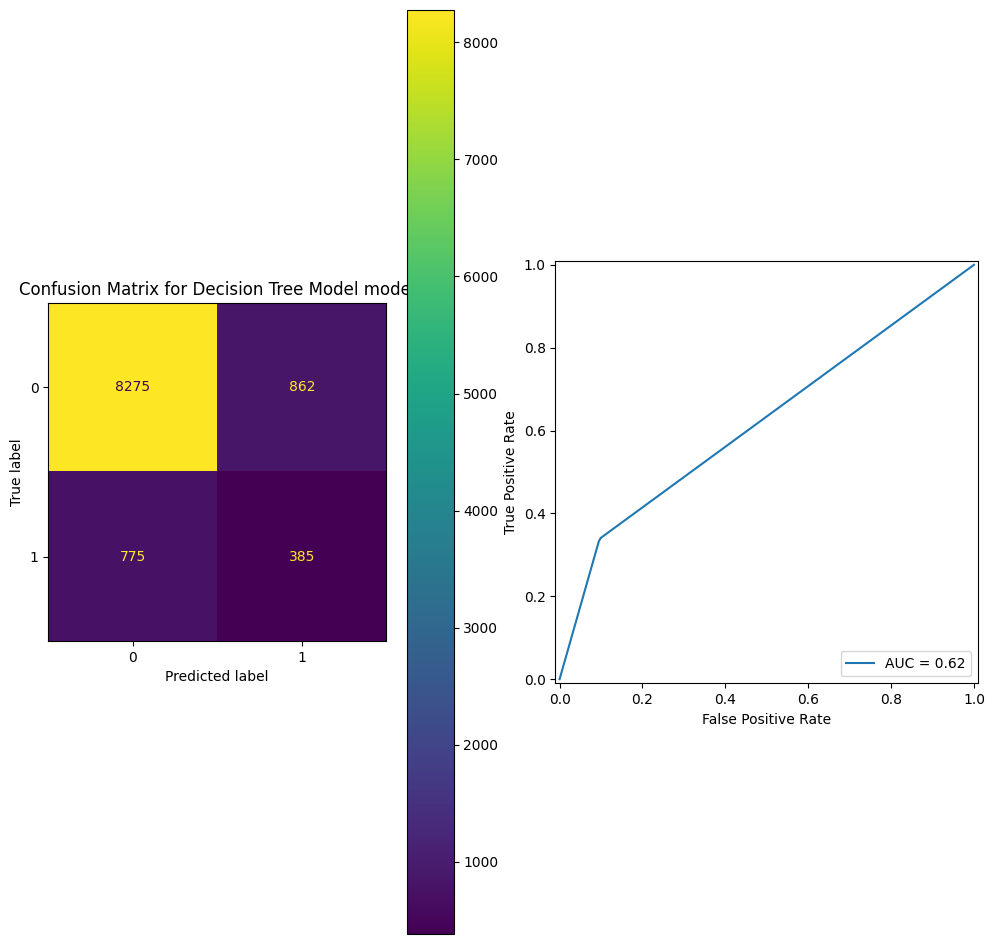

In [32]:
#Calculate confusion matrix and plot the ROC curve

dtree_fp, dtree_fn, dtree_tp, dtree_tn, dtree_auc, dtree_precision, dtree_recall = prac3app_utils.score_model_and_plot_roc_curve(dtree_pipe, 
                                                                                                                  X_test, 
                                                                                                                  y_test, 
                                                                                                                  'Decision Tree Model')
# create a dataframe row for  Decision Tree  metrics
dtree_row = pd.DataFrame([{'Model': 'Decision Trees', 'Train Time': dtree_train_time, 'Train Accuracy': dtree_pipe_train_acc, 
                        "Test Accuracy": dtree_pipe_test_acc, 'Recall': dtree_recall, 'Precision':dtree_precision}], index = [1])

In [33]:

# KNearest Neighbors pipe
knn_pipe = Pipeline([ ('col_transformer', col_transformer), 
                      ("model", KNeighborsClassifier())])

# Utility function to fit on the training data, calculate training time along with test/train accuracy.
knn_train_time, knn_pipe_test_acc, knn_pipe_train_acc =  prac3app_utils.fit_pipe(knn_pipe,  X_train, y_train, X_test, y_test)



print(knn_train_time, knn_pipe_test_acc, knn_pipe_train_acc)



0.05 0.9 0.91


fp: 252 fn: 817 tp: 343 tn: 8885 auc: 0.74
recall: 0.3  precision: 0.58


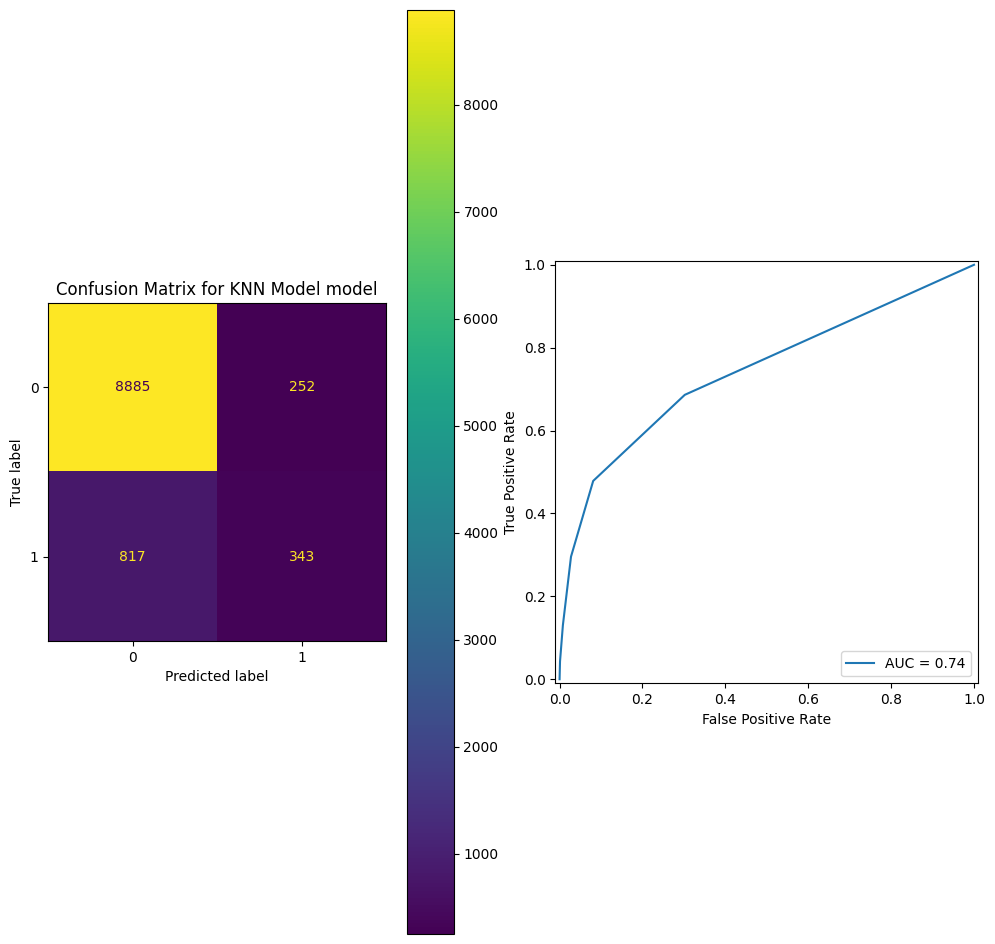

In [34]:
#Calculate confusion matrix and plot the ROC curve
knn_fp, knn_fn, knn_tp, knn_tn, knn_auc, knn_precision, knn_recall = prac3app_utils.score_model_and_plot_roc_curve(
    knn_pipe, 
    X_test, 
    y_test, 
    'KNN Model')

# create a dataframe row for  KNearest Neighbors  metrics
knn_row = pd.DataFrame([{'Model': 'KNN', 'Train Time': knn_train_time, 'Train Accuracy': knn_pipe_train_acc, 
                        "Test Accuracy": knn_pipe_test_acc, 'Recall':knn_recall, 'Precision': knn_precision}], index = [2])


In [35]:

# SVC pipe
svc_pipe = Pipeline([ ('col_transformer', col_transformer), 
                     ("model", SVC(probability=True))])
# Utility function to fit on the training data, calculate training time along with test/train accuracy.
svc_train_time, svc_pipe_test_acc, svc_pipe_train_acc =  prac3app_utils.fit_pipe(svc_pipe,  X_train, y_train, X_test, y_test)



print(svc_train_time, svc_pipe_test_acc, svc_pipe_train_acc)



159.26 0.9 0.9


fp: 108 fn: 889 tp: 271 tn: 9029 auc: 0.7
recall: 0.23  precision: 0.72


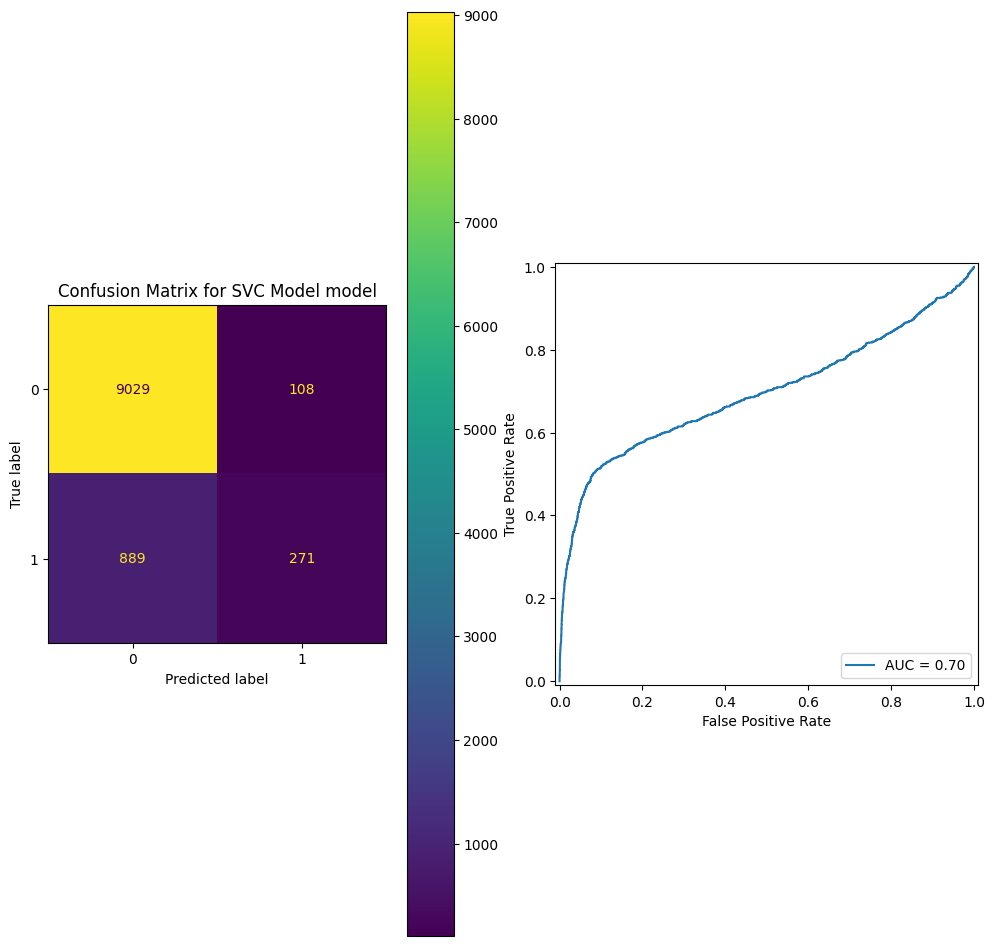

In [36]:
#Calculate confusion matrix and plot the ROC curve

svc_fp, svc_fn, svc_tp, svc_tn, svc_auc, svc_precision, svc_recall = prac3app_utils.score_model_and_plot_roc_curve(
    svc_pipe, X_test, y_test, 'SVC Model')

# create a dataframe row for  SVC metrics
svc_row = pd.DataFrame([{'Model': 'SVC', 'Train Time': svc_train_time, 'Train Accuracy': svc_pipe_train_acc, 
                        "Test Accuracy": svc_pipe_test_acc, 'Recall': svc_recall, 'Precision': svc_precision }], index = [3])

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [37]:
model_score_df = pd.concat([lgr_row, dtree_row], ignore_index=True)
model_score_df = pd.concat([model_score_df, knn_row], ignore_index=True)
model_score_df = pd.concat([model_score_df, svc_row], ignore_index=True)
model_score_df
model_score_df

,Model,Train Time,Train Accuracy,Test Accuracy,Recall,Precision
0,Logistic Regression,0.09,0.90,0.90,0.21,0.70
1,Decision Trees,0.39,1.00,0.84,0.33,0.31
2,KNN,0.05,0.91,0.90,0.30,0.58
3,SVC,159.26,0.90,0.90,0.23,0.72


1. Since the primary business objective is to increase successful sales of long-term deposits, we should try to optimize recall. 
    - False Positives (predicting a sale when there isn't one): The costs are relatively low, primarily involving some lost effort.
    - False Negatives (predicting no sale when there would have been one): This represents a  lost opportunity to acquire a long-term deposit. So we should try to minimize False Negatives.

2. Optimizing recall means focusing on predicting True positives accurately and minimizing False negatives.

Decision Trees has the highest recall but it is also showing high training accuracy which may lead to overfitting.  This explains lower test accuracy for Decision Trees as compared to others. recall values are low in general and it can be explained by the imbalanced data set where the 'yes' class is only about 11%


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Should we keep the gender feature? Why or why not?


The gender feature is not included in the csv data. I downloaded the paper from 
https://repositorio.iscteiul.pt/bitstream/10071/9499/5/dss_v3.pdf and tried to understand the analysis done for the gender feature.  The feature refers to the gender of an agent (male/female) who either made  outbound calls or received inbound calls. 

In the mutli-step feature selection process, gender was chosen as one of the features (Refer to Table 2) after satisfying the AUC  threshold check. However, the subsequent evaluation using a Neural Network established less relative predictive importance as
 compared to other features in Figure 4.





#### Hyperparameter Tuning

Let's use GridSearchCV to tune hyperparameters.

1. Logistic Regression Hyperparameters
    - C 
    - penalty 
2. Decision Tree Hyperpatameters
   - max depth
    - ceriterion
4. KNearest Neighbors
    - n_neighbors
    - weights
6. SVC (probability is not set to True as it was taking too long to run the grid search)
    - kernel

Only one parameter is chosen for SVC due to compute intensive nature of SVC.


In [38]:
# GridSearchCV for Logistic Regression
lgr_pipe_cv = Pipeline([
    ('col_transformer', col_transformer),
    ('lgr', LogisticRegression(solver='liblinear', random_state=42))
])

lgr_param_grid = {
        'lgr__C': [0.1, 1.0, 10.0],       
        'lgr__penalty': ['l1', 'l2']      
    }

# Create a custom scorer for recall, specifying the positive label
#    The make_scorer function allows you to define a custom scoring function
#    and specify parameters like 'pos_label'.
recall_scorer = make_scorer(recall_score, pos_label='yes')

lgr_grid_search = GridSearchCV(lgr_pipe_cv, lgr_param_grid, cv=5, scoring=recall_scorer, n_jobs=-1)
start_lgr_grid_search_time = time.time()
lgr_grid_search.fit(X_train, y_train)
end_lgr_grid_search_time = time.time()

lgr_train_time = round(end_lgr_grid_search_time - start_lgr_grid_search_time, 2)

In [39]:
# Extract best parameters after the grid search and calculate accuracy for train/test data
print(f"Best parameters: {lgr_grid_search.best_params_}")
print(f"Best cross-validation score: {lgr_grid_search.best_score_}")

best_model = lgr_grid_search.best_estimator_
lgr_pipe_test_acc = round(best_model.score(X_test, y_test), 2)
lgr_pipe_train_acc = round(best_model.score(X_train, y_train), 2)
lgr_pipe_test_acc, lgr_pipe_train_acc


Best parameters: {'lgr__C': 10.0, 'lgr__penalty': 'l1'}
Best cross-validation score: 0.22557471264367815


(0.9, 0.9)

fp: 112 fn: 910 tp: 250 tn: 9025 auc: 0.81
recall: 0.22  precision: 0.69


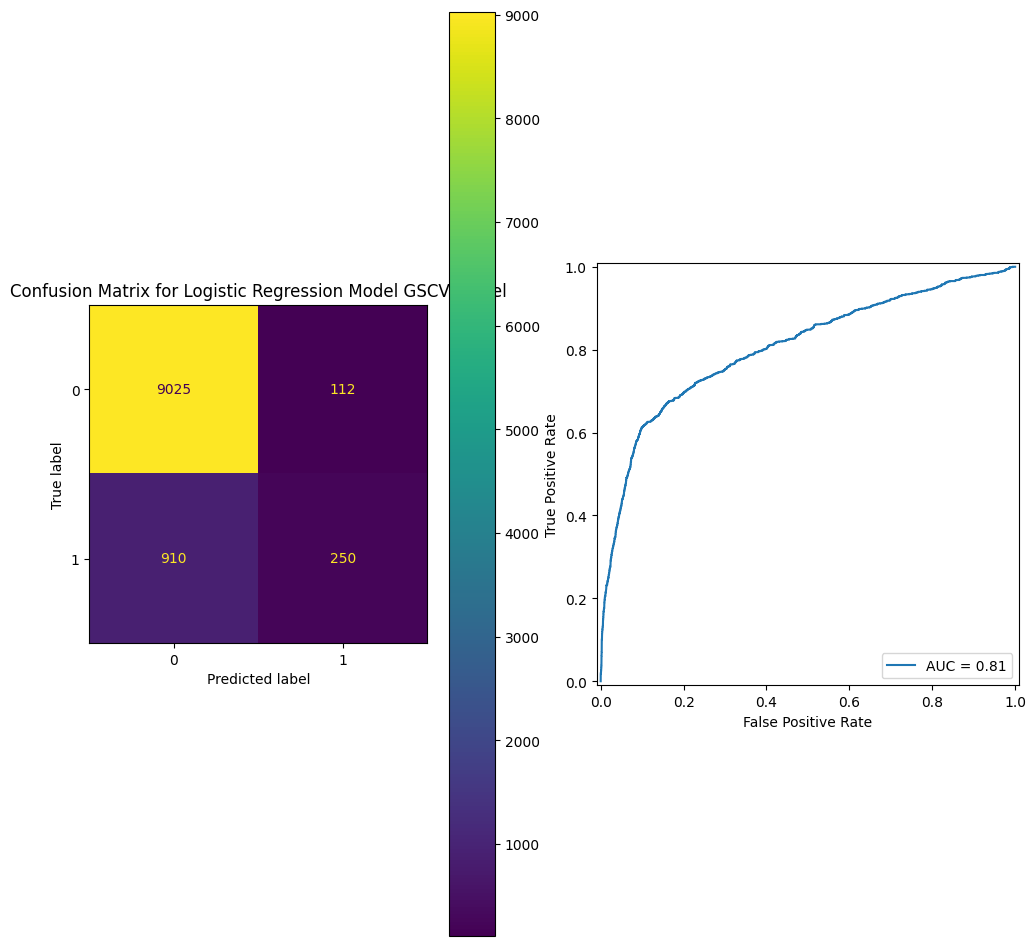

In [40]:
#Calculate confusion matrix and plot the ROC curve
lgr_fp, lgr_fn, lgr_tp, lgr_tn, lgr_auc, lgr_precision, lgr_recall = prac3app_utils.score_model_and_plot_roc_curve(
    lgr_grid_search.best_estimator_, 
    X_test, 
    y_test, 
    'Logistic Regression Model GSCV')

In [41]:
#GridSearchCV for Decision Tree
dtree_pipe_cv = Pipeline([ ('col_transformer', col_transformer), 
                     ("model", DecisionTreeClassifier())])



dtree_param_grid = {
    'model__max_depth': [None, 10, 20],
    'model__criterion': ['gini', 'entropy']
}

# Create a custom scorer for recall, specifying the positive label
#    The make_scorer function allows you to define a custom scoring function
#    and specify parameters like 'pos_label'.
recall_scorer = make_scorer(recall_score, pos_label='yes')

In [42]:
dtree_grid_search = GridSearchCV(dtree_pipe_cv, dtree_param_grid, cv=5, scoring=recall_scorer, n_jobs=-1)
start_dtree_grid_search = time.time()
dtree_grid_search.fit(X_train, y_train)
end_dtree_grid_search = time.time()
dtree_train_time = round(end_dtree_grid_search - start_dtree_grid_search, 2)

In [43]:
# Extract best parameters after the grid search and calculate accuracy for train/test data
print(f"Best parameters: {dtree_grid_search.best_params_}")
print(f"Best cross-validation score: {dtree_grid_search.best_score_}")

best_model = dtree_grid_search.best_estimator_
dtree_pipe_test_acc = round(best_model.score(X_test, y_test), 2)
dtree_pipe_train_acc = round(best_model.score(X_train, y_train), 2)
dtree_pipe_test_acc, dtree_pipe_train_acc

Best parameters: {'model__criterion': 'entropy', 'model__max_depth': None}
Best cross-validation score: 0.33965517241379317


(0.84, 1.0)

fp: 833 fn: 766 tp: 394 tn: 8304 auc: 0.63
recall: 0.34  precision: 0.32


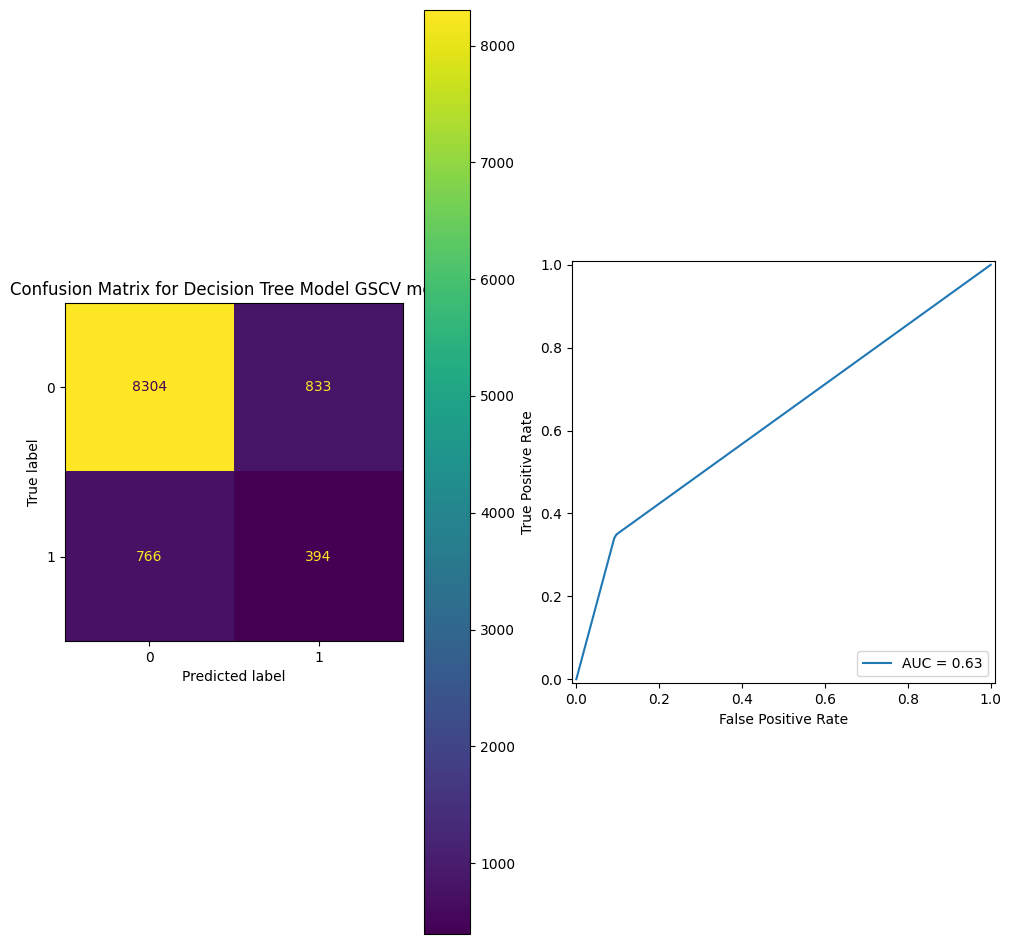

In [44]:
#Calculate confusion matrix and plot the ROC curve
dtree_fp, dtree_fn, dtree_tp, dtree_tn, dtree_auc, dtree_precision, dtree_recall = prac3app_utils.score_model_and_plot_roc_curve(
    dtree_grid_search.best_estimator_, 
    X_test, 
    y_test, 
    'Decision Tree Model GSCV')

In [45]:
knn_pipe_cv = Pipeline([ ('col_transformer', col_transformer), 
                      ("model", KNeighborsClassifier())])

knn_param_grid = {
    'model__n_neighbors': [5, 10, 15],
    'model__weights': ['uniform', 'distance']
}

# Create a custom scorer for recall, specifying the positive label
#    The make_scorer function allows you to define a custom scoring function
#    and specify parameters like 'pos_label'.
recall_scorer = make_scorer(recall_score, pos_label='yes')

In [46]:
knn_grid_search = GridSearchCV(knn_pipe_cv, knn_param_grid, cv=5, scoring=recall_scorer, n_jobs=-1)
start_knn_grid_search_time = time.time()
knn_grid_search.fit(X_train, y_train)
end_knn_grid_search_time = time.time()

knn_train_time = round(end_knn_grid_search_time - start_knn_grid_search_time, 2)

/Users/praz/Files/JupyterNotebookVenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [47]:
# Extract best parameters after the grid search and calculate accuracy for train/test data

print(f"Best parameters: {knn_grid_search.best_params_}")
print(f"Best cross-validation score: {knn_grid_search.best_score_}")

best_model = knn_grid_search.best_estimator_
knn_pipe_test_acc = round(best_model.score(X_test, y_test), 2)
knn_pipe_train_acc = round(best_model.score(X_train, y_train), 2)
knn_pipe_test_acc, knn_pipe_train_acc

Best parameters: {'model__n_neighbors': 5, 'model__weights': 'distance'}
Best cross-validation score: 0.26752873563218393


(0.89, 1.0)

fp: 327 fn: 808 tp: 352 tn: 8810 auc: 0.73
recall: 0.3  precision: 0.52


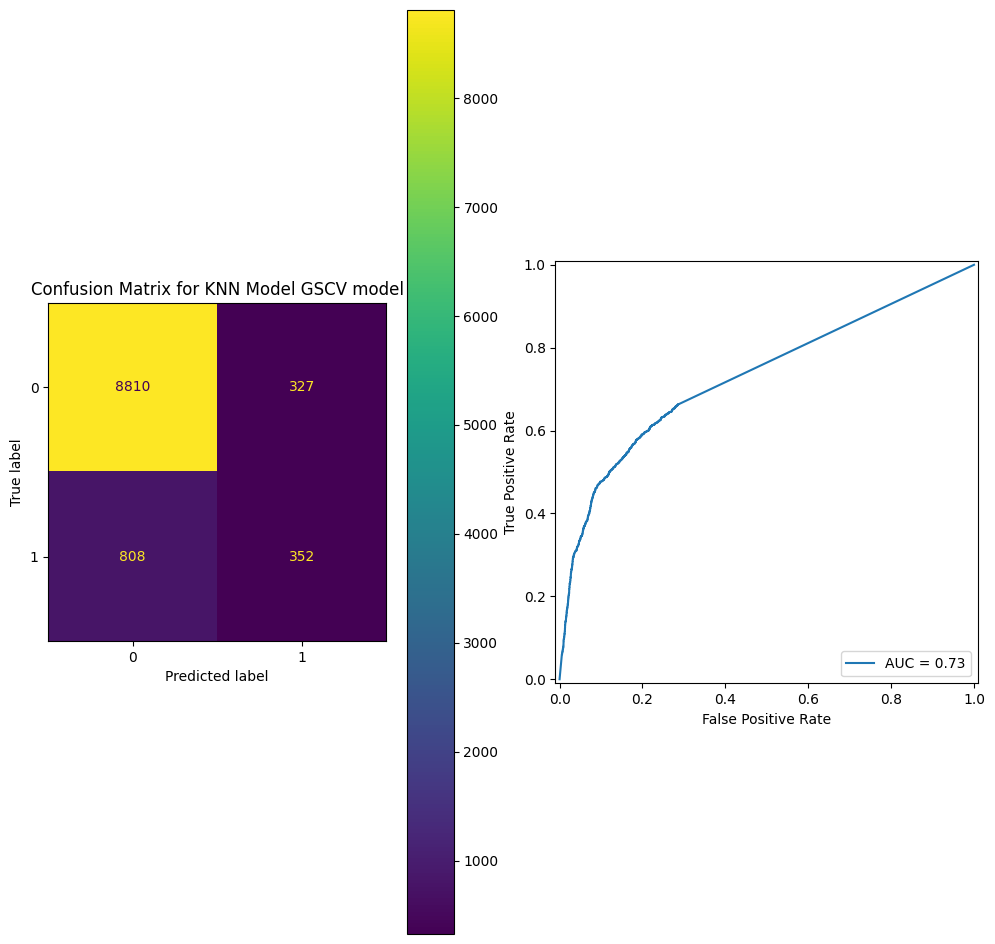

In [48]:
#Calculate confusion matrix and plot the ROC curve
knn_fp, knn_fn, knn_tp, knn_tn, knn_auc, knn_precision, knn_recall = prac3app_utils.score_model_and_plot_roc_curve(
    knn_grid_search.best_estimator_, 
    X_test, 
    y_test, 
    'KNN Model GSCV')

In [49]:
#GridSearchCV for SVC
svc_pipe_cv = Pipeline([ ('col_transformer', col_transformer), 
                         ("model", SVC())])

svc_param_grid = {
    'model__kernel': ['rbf', 'poly']
}
# Create a custom scorer for recall, specifying the positive label
#    The make_scorer function allows you to define a custom scoring function
#    and specify parameters like 'pos_label'.
recall_scorer = make_scorer(recall_score, pos_label='yes')

In [50]:

svc_grid_search = GridSearchCV(svc_pipe_cv, svc_param_grid, cv=5, scoring=recall_scorer, n_jobs=-1)
start_svc_grid_search_time = time.time()
svc_grid_search.fit(X_train, y_train)
end_svc_grid_search_time = time.time()

svc_train_time = round(end_svc_grid_search_time - start_svc_grid_search_time, 2)

In [51]:
# Extract best parameters after the grid search and calculate accuracy for train/test data

print(f"Best parameters: {svc_grid_search.best_params_}")
print(f"Best cross-validation score: {svc_grid_search.best_score_}")

best_model = svc_grid_search.best_estimator_
svc_pipe_test_acc = round(best_model.score(X_test, y_test), 2)
svc_pipe_train_acc = round(best_model.score(X_train, y_train), 2)
svc_pipe_test_acc, svc_pipe_train_acc

Best parameters: {'model__kernel': 'poly'}
Best cross-validation score: 0.22902298850574715


(0.9, 0.91)

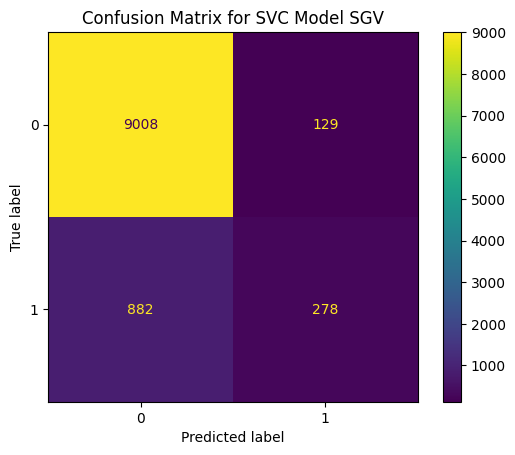

fp: 129 fn: 882 tp: 278 tn: 9008
recall: 0.24  precision: 0.68


In [52]:
#Calculate confusion matrix. No ROC curve as probability is not set to True for SVC

svc_fp, svc_fn, svc_tp, svc_tn, svc_auc, svc_precision, svc_recall = prac3app_utils.score_model(
    svc_grid_search.best_estimator_, X_test, y_test, 'SVC Model SGV')

In [53]:
#Create evaluation metrics dataframe for GridSearchCV for Logistic Reg, Decision Trees,   KNearest Neighbors and SVC

model_score_gscv_df = pd.DataFrame(columns=['Grid Search CV Model', 'Train Time', 'Train Accuracy', 'Test Accuracy', 'Recall', 'Precision'])

lgr_gscv_row = pd.DataFrame([{'Grid Search CV Model': 'Logistic Regression', 'Train Time': lgr_train_time, 'Train Accuracy': lgr_pipe_train_acc, 
                        "Test Accuracy": lgr_pipe_test_acc, 'Recall': lgr_recall, 'Precision':lgr_precision}], index = [0])
dtree_gscv_row = pd.DataFrame([{'Grid Search CV Model': 'Decision Trees', 'Train Time': dtree_train_time, 'Train Accuracy': dtree_pipe_train_acc, 
                        "Test Accuracy": dtree_pipe_test_acc, 'Recall': dtree_recall, 'Precision':dtree_precision}], index = [1])
# create a dataframe row for  KNearest Neighbors  metrics
knn_gscv_row = pd.DataFrame([{'Grid Search CV Model': 'KNN', 'Train Time': knn_train_time, 'Train Accuracy': knn_pipe_train_acc, 
                        "Test Accuracy": knn_pipe_test_acc, 'Recall':knn_recall, 'Precision': knn_precision}], index = [2])
# create a dataframe row for  SVC metrics
svc_gscv_row = pd.DataFrame([{'Grid Search CV Model': 'SVC', 'Train Time': svc_train_time, 'Train Accuracy': svc_pipe_train_acc, 
                        "Test Accuracy": svc_pipe_test_acc, 'Recall': svc_recall, 'Precision': svc_precision }], index = [3])

model_score_gscv_df = pd.concat([lgr_gscv_row, dtree_gscv_row], ignore_index=True)
model_score_gscv_df = pd.concat([model_score_gscv_df, knn_gscv_row], ignore_index=True)
model_score_gscv_df = pd.concat([model_score_gscv_df, svc_gscv_row], ignore_index=True)
model_score_gscv_df

,Grid Search CV Model,Train Time,Train Accuracy,Test Accuracy,Recall,Precision
0,Logistic Regression,6.90,0.90,0.90,0.22,0.69
1,Decision Trees,2.23,1.00,0.84,0.34,0.32
2,KNN,30.69,1.00,0.89,0.30,0.52
3,SVC,80.54,0.91,0.90,0.24,0.68


In [54]:
model_score_df

,Model,Train Time,Train Accuracy,Test Accuracy,Recall,Precision
0,Logistic Regression,0.09,0.90,0.90,0.21,0.70
1,Decision Trees,0.39,1.00,0.84,0.33,0.31
2,KNN,0.05,0.91,0.90,0.30,0.58
3,SVC,159.26,0.90,0.90,0.23,0.72


Evaluation metrics are quite similar with and without GridSearchCV except for the following:
1. KNN & SVC precision metrics have reduced.
2. Training accuracy for KNN has gone up by 9 percent.
3. Training times would be higher for GridSearchCV for obvious reasons. GridSearchCV SVC training time is faster than simple SVC training. I observed this pattern only in the latest run. I am running my Notebook on a new MacBook Pro with GPUs. When I ran this notebook on Colab (with a pro subscription), it took longer than my macbook. I cannot explain this and will look into it.

In terms of next steps, I would like to understand the Neural Networks model in detail that is presented in the research paper.

I want to point out that I did not instantiate SVC with probability set to True for grid search to save compute cycles. It was taking too long to run the grid search with that option.



##### Questions